## 1. Installation & Imports

In [1]:
# Install dependencies (uncomment if needed)
# !pip install pybgpkit networkx scipy numpy pandas matplotlib seaborn tqdm

In [2]:
import os
import time
import json
import logging
import warnings
from datetime import datetime, timedelta, timezone
from pathlib import Path
from collections import defaultdict
from typing import Optional, Dict, List, Tuple, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy import stats as sp_stats
import bgpkit

warnings.filterwarnings('ignore', category=FutureWarning)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Optional: NetworKit for high-performance computation on large graphs
try:
    import networkit as nk
    HAS_NETWORKIT = True
    logger.info("NetworKit available - will use for performance-critical computations")
except ImportError:
    HAS_NETWORKIT = False
    logger.info("NetworKit not available - using NetworkX only (slower for large graphs)")

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"NetworKit available: {HAS_NETWORKIT}")

2026-02-26 15:13:35,674 - INFO - NetworKit available - will use for performance-critical computations


NetworkX version: 3.4.2
NumPy version: 2.2.6
NetworKit available: True


## 2. Configuration

All parameters are configurable. Adjust the collector, date range, and processing mode below.

In [3]:
# ============================================================================
# CONFIGURATION - Modify these parameters as needed
# ============================================================================

# --- RIPE RIS Collector ---
COLLECTOR = "rrc25"

# --- Date Range ---
START_DATE = "2025-11-19"  # YYYY-MM-DD
END_DATE = "2025-11-20"    # YYYY-MM-DD (inclusive)

# --- Ego-Network Settings ---
# TARGET_AS: The AS number to center the ego-network on.
#   This is the AS whose local neighborhood you want to monitor.
#   Examples: 174 (Cogent), 3356 (Lumen/Level3), 13335 (Cloudflare),
#             1299 (Arelion/Telia), 6939 (Hurricane Electric)
TARGET_AS = 49666  # <-- CHANGE THIS to your AS of interest

# EGO_K_HOP: Number of hops from TARGET_AS to include in the subgraph.
#   1-hop = TARGET_AS + direct peers only (star-like, limited structure)
#   2-hop = TARGET_AS + peers + peers-of-peers (recommended, captures local topology)
#   3-hop = larger neighborhood (slower, but more context)
EGO_K_HOP = 2

# --- Output Directories ---
BASE_DIR = Path("/home/smotaali/First_Full_Paper/bgp_graph_features_results")
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output"
FIGURES_DIR = BASE_DIR / "figures"

for d in [DATA_DIR, OUTPUT_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Per-Snapshot Processing ---
PER_SNAPSHOT_CSV = True  # Save a separate CSV for each RIB file
SNAPSHOTS_DIR = OUTPUT_DIR / "snapshots"
SNAPSHOTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Private / Reserved ASN Ranges (to be filtered out) ---
PRIVATE_ASNS = (
    set(range(64512, 65535))              # 16-bit private (RFC 6996)
    | set(range(4200000000, 4294967295))  # 32-bit private (RFC 6996)
    | {0, 23456, 65535, 4294967295}       # reserved / special (RFC 7300)
)

def is_valid_public_asn(asn: int) -> bool:
    """Return True if the ASN is a valid public (non-private, non-reserved) ASN."""
    return asn not in PRIVATE_ASNS

# --- Performance Settings ---
BETWEENNESS_SAMPLE_K = None  # None = exact (feasible on small ego subgraphs)
COMPUTE_SPECTRAL = True
MAX_NODES_FOR_CLIQUE = 5000  # ego subgraphs are typically well under this

# --- RIPE RIS URL Pattern ---
RIPE_BASE_URL = "https://data.ris.ripe.net"

print(f"Configuration:")
print(f"  Collector: {COLLECTOR}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Target AS: {TARGET_AS}")
print(f"  Ego-network hops: {EGO_K_HOP}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Snapshots dir: {SNAPSHOTS_DIR}")
print(f"  Private ASN filter: {len(PRIVATE_ASNS):,} ASNs will be excluded")
print(f"  Betweenness sampling: {'exact' if BETWEENNESS_SAMPLE_K is None else f'k={BETWEENNESS_SAMPLE_K}'}")

# --- Reproducibility ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Collector: rrc25
  Date range: 2025-11-19 to 2025-11-20
  Target AS: 49666
  Ego-network hops: 2
  Output: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output
  Snapshots dir: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output/snapshots
  Private ASN filter: 94,968,322 ASNs will be excluded
  Betweenness sampling: exact
  Random seed: 42


## 3. Data Discovery & Download

Uses BGPKIT Broker to discover available MRT files for the configured collector and time range,
then constructs direct URLs for RIB dumps (`bview.*`).

**RIPE RIS URL pattern:**
```
https://data.ris.ripe.net/{collector}/{YYYY.MM}/bview.{YYYYMMDD}.{HHMM}.gz
```

RIB dumps are generated every **8 hours** at 00:00, 08:00, 16:00 UTC.

In [4]:
def generate_rib_urls(collector: str, start_date: str, end_date: str) -> List[str]:
    """
    Generate URLs for all RIB dump files in the given date range.
    RIB dumps are available at 00:00, 08:00, 16:00 UTC daily.
    """
    urls = []
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    rib_hours = [0, 8, 16]

    current = start
    while current <= end:
        year_month = current.strftime("%Y.%m")
        for hour in rib_hours:
            ts = current.replace(hour=hour, minute=0)
            if ts < start or ts > end :
                continue
            filename = f"bview.{ts.strftime('%Y%m%d.%H%M')}.gz"
            url = f"{RIPE_BASE_URL}/{collector}/{year_month}/{filename}"
            urls.append(url)
        current += timedelta(days=1)

    return urls


def discover_files_via_broker(collector: str, start_date: str, end_date: str) -> List[dict]:
    """
    Use BGPKIT Broker to discover available RIB MRT files.
    Falls back to URL generation if Broker is unavailable.
    """
    try:
        broker = bgpkit.Broker()
        items = broker.query(
            ts_start=f"{start_date}T00:00:00",
            ts_end=f"{end_date}T00:00:01",
            collector_id=collector,
            data_type="rib"
        )
        if items:
            logger.info(f"Broker found {len(items)} RIB files")
            return items
    except Exception as e:
        logger.warning(f"Broker query failed: {e}. Falling back to URL generation.")

    urls = generate_rib_urls(collector, start_date, end_date)
    logger.info(f"Generated {len(urls)} RIB URLs")
    return [{"url": url} for url in urls]


# Discover RIB files
rib_files = discover_files_via_broker(COLLECTOR, START_DATE, END_DATE)
print(f"\nRIB files discovered: {len(rib_files)}")
for f in rib_files[:5]:
    url = f['url'] if isinstance(f, dict) else f.url
    print(f"  {url}")

2026-02-26 15:13:55,779 - INFO - Broker found 4 RIB files



RIB files discovered: 4
  https://data.ris.ripe.net/rrc25/2025.11/bview.20251119.0000.gz
  https://data.ris.ripe.net/rrc25/2025.11/bview.20251119.0800.gz
  https://data.ris.ripe.net/rrc25/2025.11/bview.20251119.1600.gz
  https://data.ris.ripe.net/rrc25/2025.11/bview.20251120.0000.gz


In [5]:
import urllib.request

def parse_as_path(as_path_str: str) -> List[int]:
    """
    Parse an AS_PATH string into a deduplicated list of valid public ASNs.
    Handles:
    - Standard AS paths: "3356 1299 13335"
    - AS prepending: "3356 3356 3356 1299" -> [3356, 1299]
    - AS_SETs: "{1234,5678}" -> skipped entirely
    - Private/reserved ASNs: filtered out (RFC 6996, RFC 7300)
    """
    if not as_path_str:
        return []

    tokens = as_path_str.split()
    deduped = []
    for token in tokens:
        if '{' in token or '}' in token:
            continue
        try:
            asn = int(token)
            if not is_valid_public_asn(asn):
                continue
            if not deduped or asn != deduped[-1]:
                deduped.append(asn)
        except ValueError:
            continue
    return deduped


def extract_edges_from_as_path(as_path: List[int]) -> List[Tuple[int, int]]:
    """
    Extract pairwise AS adjacency edges from a parsed AS path.
    Returns a list (not set) so callers can count occurrences for weighting.
    """
    edges = []
    for i in range(len(as_path) - 1):
        edge = tuple(sorted([as_path[i], as_path[i + 1]]))
        if edge[0] != edge[1]:
            edges.append(edge)
    return edges


def download_mrt_file(url: str, dest_dir: Path) -> Path:
    """Download an MRT file and save it locally. Returns the local file path."""
    filename = url.split('/')[-1]
    local_path = dest_dir / filename

    if local_path.exists():
        size_mb = local_path.stat().st_size / (1024 * 1024)
        logger.info(f"  Already downloaded: {filename} ({size_mb:.1f} MB)")
        return local_path

    logger.info(f"  Downloading: {filename}")
    t0 = time.time()
    urllib.request.urlretrieve(url, str(local_path))
    elapsed = time.time() - t0
    size_mb = local_path.stat().st_size / (1024 * 1024)
    logger.info(f"  Saved: {filename} ({size_mb:.1f} MB, {elapsed:.1f}s)")
    return local_path


def parse_mrt_to_rows(file_path: str) -> Tuple[List[dict], dict]:
    """
    Parse a single MRT RIB dump file into structured TABLE_DUMP2 rows.

    Each RIB entry is mapped to:
        TABLE_DUMP2|timestamp|B|peer_ip|peer_as|prefix|as_path|origin|
        next_hop|local_pref|med|community|atomic_agg|aggregator

    Returns:
        rows: list of dicts (one per RIB entry)
        stats: parsing statistics
    """
    rows = []
    stats = {
        'total_elements': 0,
        'announcements': 0,
        'withdrawals': 0,
        'unique_prefixes': set(),
        'unique_peers': set(),
        'parse_errors': 0,
    }

    logger.info(f"  Parsing: {Path(file_path).name}")
    t0 = time.time()

    try:
        parser = bgpkit.Parser(url=str(file_path))
        for elem in parser:
            stats['total_elements'] += 1

            if elem.elem_type == "W":
                stats['withdrawals'] += 1
                continue

            stats['announcements'] += 1

            if elem.prefix:
                stats['unique_prefixes'].add(elem.prefix)
            if elem.peer_asn:
                stats['unique_peers'].add(elem.peer_asn)

            # Convert timestamp to readable UTC string
            ts = datetime.fromtimestamp(
                elem.timestamp, tz=timezone.utc
            ).strftime('%Y-%m-%d %H:%M:%S')

            # Build community string (space-separated)
            communities = ''
            if elem.communities:
                communities = ' '.join(str(c) for c in elem.communities)

            # Build aggregator string
            aggregator = ''
            aggr_asn = getattr(elem, 'aggr_asn', None)
            aggr_ip = getattr(elem, 'aggr_ip', None)
            if aggr_asn:
                aggregator = f"{aggr_asn} {aggr_ip}".strip() if aggr_ip else str(aggr_asn)

            row = {
                'MRT_Type': 'TABLE_DUMP2',
                'Timestamp': ts,
                'Entry_Type': 'B',
                'Peer_IP': elem.peer_ip or '',
                'Peer_AS': elem.peer_asn if elem.peer_asn else '',
                'Prefix': elem.prefix or '',
                'AS_Path': elem.as_path or '',
                'Origin': elem.origin or '',
                'Next_Hop': elem.next_hop or '',
                'Local_Pref': elem.local_pref if elem.local_pref is not None else '',
                'MED': elem.med if elem.med is not None else '',
                'Community': communities,
                'Atomic_Aggregate': 'AG' if elem.atomic else '',
                'Aggregator': aggregator,
            }
            rows.append(row)

    except Exception as e:
        logger.error(f"Error parsing {file_path}: {e}")
        stats['parse_errors'] += 1

    elapsed = time.time() - t0
    stats['unique_prefixes'] = len(stats['unique_prefixes'])
    stats['unique_peers'] = len(stats['unique_peers'])
    stats['rows_parsed'] = len(rows)
    stats['parse_time_sec'] = round(elapsed, 2)

    logger.info(
        f"  -> {stats['total_elements']:,} elements, "
        f"{len(rows):,} rows, {stats['unique_prefixes']:,} prefixes, "
        f"{stats['unique_peers']:,} peers in {elapsed:.1f}s"
    )
    return rows, stats


print("Parse functions defined:")
print("  - parse_as_path(as_path_str) -> List[int]")
print("  - extract_edges_from_as_path(as_path) -> List[Tuple[int,int]]")
print("  - download_mrt_file(url, dest_dir) -> Path")
print("  - parse_mrt_to_rows(file_path) -> (rows, stats)")

Parse functions defined:
  - parse_as_path(as_path_str) -> List[int]
  - extract_edges_from_as_path(as_path) -> List[Tuple[int,int]]
  - download_mrt_file(url, dest_dir) -> Path
  - parse_mrt_to_rows(file_path) -> (rows, stats)


In [ ]:
# ============================================================================
# STEP 1: Download MRT files locally & parse to structured CSV
# ============================================================================
# Downloads raw MRT .gz files and parses every RIB entry into CSV format.
# Also saves per-snapshot CSVs and builds a snapshot manifest.
# Caches results: if per-snapshot CSVs and manifest already exist, skips
# the download+parse entirely (saves ~20 min on re-runs).
# ============================================================================

MRT_DIR = DATA_DIR / "mrt_files"
MRT_DIR.mkdir(parents=True, exist_ok=True)


# Build suffix early so it is available in the re-parse branch too
if TARGET_AS:
    _suffix = f"{COLLECTOR}_AS{TARGET_AS}_{EGO_K_HOP}hop_{START_DATE}_{END_DATE}"
else:
    _suffix = f"{COLLECTOR}_{START_DATE}_{END_DATE}"

manifest_csv_path = OUTPUT_DIR / f"snapshot_manifest_{_suffix}.csv"


csv_path = OUTPUT_DIR / f"rib_parsed_{_suffix}.csv"

# --- Check if cached results already exist ---
cache_valid = False
if manifest_csv_path.exists():
    manifest_df = pd.read_csv(manifest_csv_path)
    all_snap_csvs_exist = all(Path(p).exists() for p in manifest_df['csv_path'])
    if all_snap_csvs_exist and len(manifest_df) > 0:
        snapshot_manifest = manifest_df.to_dict('records')
        cache_valid = True
        print("=" * 70)
        print("STEP 1: SKIPPED — cached manifest + per-snapshot CSVs found")
        print(f"  Snapshot manifest: {len(snapshot_manifest)} snapshots")
        print("=" * 70)

if not cache_valid:
    # --- Full download + parse ---
    all_rows = []
    all_stats = []
    snapshot_manifest = []

    print("=" * 70)
    print("STEP 1: DOWNLOAD MRT FILES & PARSE TO CSV")
    print("=" * 70)

    for i, f in enumerate(rib_files):
        url = f["url"] if isinstance(f, dict) else f.url
        print(f"\n[{i+1}/{len(rib_files)}] {url}")

        local_path = download_mrt_file(url, MRT_DIR)
        rows, stats = parse_mrt_to_rows(str(local_path))
        stats["file_type"] = "rib"
        stats["url"] = url
        stats["local_path"] = str(local_path)
        all_rows.extend(rows)
        all_stats.append(stats)

        # Save per-snapshot CSV
        if PER_SNAPSHOT_CSV and rows:
            filename = Path(local_path).name  # e.g. bview.20251117.0000.gz
            parts = filename.replace("bview.", "").replace(".gz", "").split(".")
            date_part, time_part = parts[0], parts[1]
            snapshot_ts = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:8]}T{time_part[:2]}:{time_part[2:]}:00Z"
            snapshot_id = f"{COLLECTOR}_{date_part}_{time_part}"

            snap_csv_path = SNAPSHOTS_DIR / f"rib_{snapshot_id}.csv"
            pd.DataFrame(rows).to_csv(snap_csv_path, index=False)

            snapshot_manifest.append({
                "snapshot_id": snapshot_id,
                "timestamp": snapshot_ts,
                "collector": COLLECTOR,
                "url": url,
                "mrt_path": str(local_path),
                "csv_path": str(snap_csv_path),
                "n_rows": len(rows),
            })
            print(f"  Snapshot CSV: {snap_csv_path.name} ({len(rows):,} rows)")

        print(f"  Running total: {len(all_rows):,} rows")

    # Save combined CSV
    rib_df = pd.DataFrame(all_rows)
    rib_df.to_csv(csv_path, index=False)

    # Save stats and manifest
    pd.DataFrame(all_stats).to_csv(OUTPUT_DIR / f"parsing_stats_{_suffix}.csv", index=False)
    manifest_csv_path = OUTPUT_DIR / f"snapshot_manifest_{_suffix}.csv"
    pd.DataFrame(snapshot_manifest).to_csv(manifest_csv_path, index=False)

    print(f"\n{'=' * 70}")
    print(f"DOWNLOAD & PARSE COMPLETE")
    print(f"  Combined CSV: {csv_path} ({csv_path.stat().st_size / (1024*1024):.1f} MB)")
    print(f"  Total rows: {len(rib_df):,}")
    print(f"  Snapshot manifest: {len(snapshot_manifest)} snapshots")
    print(f"{'=' * 70}")

2026-02-26 15:13:58,157 - INFO -   Already downloaded: bview.20251119.0000.gz (435.2 MB)
2026-02-26 15:13:58,158 - INFO -   Parsing: bview.20251119.0000.gz


STEP 1: DOWNLOAD MRT FILES & PARSE TO CSV

[1/4] https://data.ris.ripe.net/rrc25/2025.11/bview.20251119.0000.gz


## 5. Edge Extraction Function

Build AS topology edges from a parsed RIB CSV. Called once per snapshot.

In [ ]:
from collections import Counter

def build_edges_from_csv(csv_path_or_df):
    """
    Load a per-snapshot CSV and build AS topology edges.
    OPTIMIZED: reads only AS_Path column, inlines parsing to avoid
    per-row function call overhead, and counts edges directly in a
    Counter instead of building an intermediate list.

    Args:
        csv_path_or_df: Path to CSV file or pre-loaded DataFrame

    Returns:
        all_edges: set of unique (asn_a, asn_b) edges (sorted tuple)
        edge_counts: Counter mapping edge -> observation count
    """
    if isinstance(csv_path_or_df, (str, Path)):
        df = pd.read_csv(csv_path_or_df, usecols=['AS_Path'])
    else:
        df = csv_path_or_df

    # Pre-fetch the set for fast membership testing
    _private = PRIVATE_ASNS

    # Work with numpy array of strings for faster iteration
    paths = df["AS_Path"].dropna().values.astype(str)

    edge_counts = Counter()
    for as_path_raw in paths:
        if not as_path_raw or as_path_raw == "nan":
            continue

        # --- Inlined parse_as_path + extract_edges_from_as_path ---
        tokens = as_path_raw.split()
        prev = -1  # impossible ASN sentinel
        deduped_prev = -1
        for token in tokens:
            if '{' in token:
                # Skip AS_SET tokens (may span multiple tokens)
                continue
            if '}' in token:
                continue
            try:
                asn = int(token)
            except ValueError:
                continue
            if asn in _private:
                continue
            if asn == deduped_prev:
                continue  # prepending removal
            # We have a valid, non-duplicate ASN
            if deduped_prev > 0 and asn != deduped_prev:
                # Emit edge between consecutive ASNs
                a, b = (deduped_prev, asn) if deduped_prev < asn else (asn, deduped_prev)
                edge_counts[(a, b)] += 1
            deduped_prev = asn

    all_edges = set(edge_counts.keys())
    return all_edges, edge_counts


print("Defined: build_edges_from_csv(csv_path_or_df) -> (edges, edge_counts)")
     

Defined: build_edges_from_csv(csv_path_or_df) -> (edges, edge_counts)


## 6. Graph Construction & Ego-Network Extraction


In [ ]:
def nx_to_nk(G_nx):
    """Convert a NetworkX graph to NetworKit format."""
    if not HAS_NETWORKIT:
        return None, None, None
    node_list = sorted(G_nx.nodes())
    nx2nk_map = {n: i for i, n in enumerate(node_list)}
    nk2nx_map = {i: n for n, i in nx2nk_map.items()}
    G_nk = nk.Graph(len(node_list), weighted=False, directed=False)
    for u, v in G_nx.edges():
        G_nk.addEdge(nx2nk_map[u], nx2nk_map[v])
    return G_nk, nx2nk_map, nk2nx_map


def extract_ego_subgraph(G, target_as, k_hop):
    """
    Extract k-hop ego subgraph around target_as from the full graph.

    Args:
        G: full NetworkX graph
        target_as: the center AS number
        k_hop: number of hops to include

    Returns:
        G_ego: the ego subgraph (connected component containing target_as)
        ego_info: dict with metadata about the extraction
    """
    if target_as not in G:
        return None, {"error": f"AS {target_as} not found in graph"}

    # BFS to find all nodes within k hops
    ego_nodes = set()
    ego_nodes.add(target_as)
    frontier = {target_as}
    for hop in range(k_hop):
        next_frontier = set()
        for node in frontier:
            for neighbor in G.neighbors(node):
                if neighbor not in ego_nodes:
                    next_frontier.add(neighbor)
                    ego_nodes.add(neighbor)
        frontier = next_frontier
        if not frontier:
            break

    # Extract induced subgraph
    G_ego = G.subgraph(ego_nodes).copy()

    ego_info = {
        "target_as": target_as,
        "k_hop": k_hop,
        "ego_nodes": len(ego_nodes),
        "ego_edges": G_ego.number_of_edges(),
        "target_degree_full": G.degree(target_as),
    }

    # Ensure connectivity (ego subgraph should be connected by construction,
    # but check anyway in case of graph oddities)
    if not nx.is_connected(G_ego):
        components = list(nx.connected_components(G_ego))
        # Take the component containing the target AS
        for comp in components:
            if target_as in comp:
                G_ego = G_ego.subgraph(comp).copy()
                break
        ego_info["ego_connected"] = False
        ego_info["ego_nodes_after_lcc"] = G_ego.number_of_nodes()
    else:
        ego_info["ego_connected"] = True

    return G_ego, ego_info


def build_snapshot_graph(edges, edge_counts, collector, snapshot_id, timestamp,
                         target_as=None, k_hop=2):
    """
    Build AS-level topology graph, optionally extract ego subgraph.

    If target_as is provided, extracts k-hop ego subgraph and uses that
    for all feature computation. Otherwise uses full graph LCC (original behavior).

    Returns:
        G: full graph
        G_sub: subgraph for feature computation (ego or LCC)
        G_nk: NetworKit graph of G_sub (or None)
        nx2nk_map: NetworkX->NetworKit node ID mapping (or None)
        nk2nx_map: NetworKit->NetworkX node ID mapping (or None)
        info: dict with graph metadata
    """
    G = nx.Graph()
    for (u, v), w in edge_counts.items():
        G.add_edge(u, v, weight=w)

    G.graph["name"] = f"AS-level topology ({collector}, {snapshot_id})"
    G.graph["collector"] = collector
    G.graph["snapshot_id"] = snapshot_id
    G.graph["timestamp"] = timestamp

    info = {
        "n_nodes_full": G.number_of_nodes(),
        "n_edges_full": G.number_of_edges(),
    }

    # --- Ego-network extraction ---
    if target_as is not None:
        G_ego, ego_info = extract_ego_subgraph(G, target_as, k_hop)
        info.update(ego_info)

        if G_ego is None:
            raise ValueError(f"Target AS {target_as} not found in snapshot {snapshot_id}")

        G_sub = G_ego
        info["mode"] = "ego"
        info["n_nodes"] = G_sub.number_of_nodes()
        info["n_edges"] = G_sub.number_of_edges()
        info["lcc_fraction"] = G_sub.number_of_nodes() / G.number_of_nodes()

    # --- Full graph LCC (fallback / original behavior) ---
    else:
        info["is_connected"] = nx.is_connected(G)
        info["mode"] = "full"

        if not nx.is_connected(G):
            components = list(nx.connected_components(G))
            sizes = sorted([len(c) for c in components], reverse=True)
            info["n_components"] = len(components)
            info["lcc_fraction"] = sizes[0] / G.number_of_nodes()
            largest_cc = max(components, key=len)
            G_sub = G.subgraph(largest_cc).copy()
        else:
            info["n_components"] = 1
            info["lcc_fraction"] = 1.0
            G_sub = G

        info["n_nodes"] = G_sub.number_of_nodes()
        info["n_edges"] = G_sub.number_of_edges()

    # NetworKit conversion
    G_nk, nx2nk_map, nk2nx_map = nx_to_nk(G_sub)

    return G, G_sub, G_nk, nx2nk_map, nk2nx_map, info


print("Defined: extract_ego_subgraph(G, target_as, k_hop) -> (G_ego, ego_info)")
print("Defined: build_snapshot_graph(edges, edge_counts, ..., target_as, k_hop)")
print("  Returns (G, G_sub, G_nk, nx2nk_map, nk2nx_map, info)")

Defined: extract_ego_subgraph(G, target_as, k_hop) -> (G_ego, ego_info)
Defined: build_snapshot_graph(edges, edge_counts, ..., target_as, k_hop)
  Returns (G, G_sub, G_nk, nx2nk_map, nk2nx_map, info)


## 7. Graph-Level Feature Extraction Function

Extract all 16 graph-level metrics from a single snapshot graph.
Each feature computation is wrapped in try/except for graceful failure handling.

In [ ]:
def extract_graph_level_features(G_lcc, G_nk, nk2nx_map, config):
    """
    Extract all 16 graph-level features from a snapshot's LCC graph.

    Args:
        G_lcc: NetworkX graph (largest connected component)
        G_nk: NetworKit graph (or None)
        nk2nx_map: NetworKit->NetworkX node ID mapping (or None)
        config: dict with 'compute_spectral', 'betweenness_sample_k'

    Returns:
        features: dict of feature_name -> value (None if failed)
        shared_data: dict with '_bc_map', '_core_map' for node-level reuse
    """
    features = {}
    shared_data = {}
    n_nodes = G_lcc.number_of_nodes()
    n_edges = G_lcc.number_of_edges()
    features['n_nodes'] = n_nodes
    features['n_edges'] = n_edges

    # Pre-compute sparse matrices (reused by features 5, 6, 8-11, 16)
    A_sparse = nx.adjacency_matrix(G_lcc).astype(float)
    L_sparse = nx.laplacian_matrix(G_lcc).astype(float)

    # Degree list (reused by rich-club percentiles)
    degrees = [d for _, d in G_lcc.degree()]

    # ------------------------------------------------------------------
    # 1. ASSORTATIVITY
    # Citation: Newman, Phys. Rev. Lett. 89, 208701 (2002).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        features['assortativity'] = nx.degree_assortativity_coefficient(G_lcc)
        logger.info(f"  [1/16] Assortativity: {features['assortativity']:.6f} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['assortativity'] = None
        logger.warning(f"  [1/16] Assortativity: FAILED ({e})")

    # ------------------------------------------------------------------
    # 2. DENSITY
    # ------------------------------------------------------------------
    features['density'] = nx.density(G_lcc)
    logger.info(f"  [2/16] Density: {features['density']:.8f}")

    # ------------------------------------------------------------------
    # 3. CLUSTERING COEFFICIENT
    # Citation: Watts & Strogatz, Nature 393 (1998).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            features['clustering_global'] = nk.globals.ClusteringCoefficient.exactGlobal(G_nk)
            features['clustering_avg_local'] = nk.globals.ClusteringCoefficient.sequentialAvgLocal(G_nk)
        else:
            features['clustering_global'] = nx.transitivity(G_lcc)
            features['clustering_avg_local'] = nx.average_clustering(G_lcc)
        logger.info(f"  [3/16] Clustering: global={features['clustering_global']:.6f}, "
                    f"local={features['clustering_avg_local']:.6f} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['clustering_global'] = None
        features['clustering_avg_local'] = None
        logger.warning(f"  [3/16] Clustering: FAILED ({e})")

    # ------------------------------------------------------------------
    # 4. DIAMETER & AVERAGE PATH LENGTH
    # Citation: Watts & Strogatz, Nature 393 (1998).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            diam_algo = nk.distance.Diameter(G_nk, algo=nk.distance.DiameterAlgo.AUTOMATIC)
            diam_algo.run()
            features['diameter'] = diam_algo.getDiameter()[0]
            features['diameter_approximate'] = False
        elif n_nodes < 50000:
            features['diameter'] = nx.diameter(G_lcc)
            features['diameter_approximate'] = False
        else:
            sample_nodes = np.random.choice(list(G_lcc.nodes()), size=min(100, n_nodes), replace=False)
            features['diameter'] = max(nx.eccentricity(G_lcc, v=node) for node in sample_nodes)
            features['diameter_approximate'] = True  # sampling gives a lower bound
        logger.info(f"  [4/16] Diameter: {features['diameter']} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['diameter'] = None
        logger.warning(f"  [4/16] Diameter: FAILED ({e})")

    t0 = time.time()
    try:
        if n_nodes < 20000:
            features['avg_path_length'] = nx.average_shortest_path_length(G_lcc)
        elif HAS_NETWORKIT:
            # Use NetworKit BFS for ~10x speedup over NetworkX
            sample_size = min(500, n_nodes)
            sample_nk_ids = np.random.choice(G_nk.numberOfNodes(), size=sample_size, replace=False)
            total_dist, count = 0, 0
            for nk_id in sample_nk_ids:
                bfs = nk.distance.BFS(G_nk, int(nk_id))
                bfs.run()
                dists = bfs.getDistances()
                total_dist += sum(dists)
                count += len(dists) - 1
            features['avg_path_length'] = total_dist / count if count > 0 else float('inf')
        else:
            sample_size = min(500, n_nodes)
            sample_nodes = np.random.choice(list(G_lcc.nodes()), size=sample_size, replace=False)
            total_dist, count = 0, 0
            for node in sample_nodes:
                lengths = nx.single_source_shortest_path_length(G_lcc, node)
                total_dist += sum(lengths.values())
                count += len(lengths) - 1
            features['avg_path_length'] = total_dist / count if count > 0 else float('inf')
        logger.info(f"  [4/16] Avg path length: {features['avg_path_length']:.4f} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['avg_path_length'] = None
        logger.warning(f"  [4/16] Avg path length: FAILED ({e})")

    # ------------------------------------------------------------------
    # 5. ALGEBRAIC CONNECTIVITY (Fiedler Value)
    # Use shift-invert mode (sigma near 0) for fast convergence on
    # the smallest Laplacian eigenvalues. Falls back to which='SM'.
    # Citation: Fiedler, Czech. Math. J. 23 (1973).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        try:
            eigenvalues = eigsh(L_sparse, k=2, sigma=1e-6, which='LM',
                                maxiter=5000, return_eigenvectors=False)
        except Exception:
            eigenvalues = eigsh(L_sparse, k=2, which='SM',
                                maxiter=n_nodes, return_eigenvectors=False)
        features['algebraic_connectivity'] = float(np.sort(eigenvalues)[1])
        logger.info(f"  [5/16] Algebraic connectivity: {features['algebraic_connectivity']:.6f} "
                    f"({time.time()-t0:.1f}s, sparse eigsh)")
    except Exception as e:
        features['algebraic_connectivity'] = None
        logger.warning(f"  [5/16] Algebraic connectivity: FAILED ({e})")

    # ------------------------------------------------------------------
    # 6. SPECTRAL RADIUS
    # Citation: Cvetkovic et al., Cambridge (2010).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        sr_vals = eigsh(A_sparse, k=1, which='LM', maxiter=5000,
                        return_eigenvectors=False)
        features['spectral_radius'] = float(sr_vals[0])
        logger.info(f"  [6/16] Spectral radius: {features['spectral_radius']:.4f} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['spectral_radius'] = None
        logger.warning(f"  [6/16] Spectral radius: FAILED ({e})")

    # ------------------------------------------------------------------
    # 7. PERCOLATION LIMIT
    # Citation: Pastor-Satorras & Vespignani, PRL 86 (2001).
    # ------------------------------------------------------------------
    if features.get('spectral_radius'):
        features['percolation_limit'] = 1.0 / features['spectral_radius']
        logger.info(f"  [7/16] Percolation limit: {features['percolation_limit']:.6f}")
    else:
        features['percolation_limit'] = None

    # ------------------------------------------------------------------
    # 8-11. SPECTRAL METRICS (conditional on COMPUTE_SPECTRAL)
    # Uses shift-invert mode for Laplacian eigenvalues to avoid
    # ARPACK convergence issues with which='SM' on singular matrices.
    # ------------------------------------------------------------------
    if config.get('compute_spectral', True):
        t0 = time.time()
        # 50 eigenvalues is sufficient for symmetry ratio, natural
        # connectivity, and Kirchhoff index. 300 was causing ARPACK
        # to hang on large graphs.
        n_eigs = min(n_nodes - 2, 50)
        use_full_spectrum = n_nodes < 5000

        try:
            if use_full_spectrum:
                L_dense = L_sparse.toarray()
                A_dense = A_sparse.toarray()
                laplacian_eigs = np.sort(np.real(np.linalg.eigvalsh(L_dense)))
                adjacency_eigs = np.sort(np.real(np.linalg.eigvalsh(A_dense)))[::-1]
            else:
                # Laplacian: shift-invert mode for fast convergence near 0
                try:
                    laplacian_eigs = np.sort(eigsh(
                        L_sparse, k=min(n_eigs, n_nodes-2),
                        sigma=1e-6, which='LM', maxiter=5000,
                        return_eigenvectors=False))
                except Exception as e_si:
                    logger.warning(f"  Shift-invert failed ({e_si}), falling back to which='SM'")
                    laplacian_eigs = np.sort(eigsh(
                        L_sparse, k=min(n_eigs, n_nodes-2),
                        which='SM', maxiter=n_nodes,
                        return_eigenvectors=False))
                # Adjacency: which='LM' converges fast (no issues)
                adjacency_eigs = np.sort(eigsh(
                    A_sparse, k=min(n_eigs, n_nodes-2),
                    which='LM', maxiter=5000,
                    return_eigenvectors=False))[::-1]
            logger.info(f"  Spectrum computation: {time.time()-t0:.1f}s "
                        f"({'full' if use_full_spectrum else f'partial, {len(adjacency_eigs)} eigs'})")

            # 8. SYMMETRY RATIO
            distinct_eigs = len(np.unique(np.round(adjacency_eigs, 8)))
            D = features.get('diameter', 10) or 10
            features['symmetry_ratio'] = distinct_eigs / (D + 1)
            features['symmetry_ratio_partial'] = not use_full_spectrum
            logger.info(f"  [8/16] Symmetry ratio: {features['symmetry_ratio']:.4f}")

            # 9. NATURAL CONNECTIVITY
            # NOTE: Exact formula requires full spectrum.  For partial
            # spectra the largest eigenvalues dominate exp(lambda) so
            # the approximation is reasonable, but we flag it.
            max_eig = np.max(adjacency_eigs)
            shifted = np.exp(adjacency_eigs - max_eig)
            if use_full_spectrum:
                features['natural_connectivity'] = float(max_eig + np.log(np.mean(shifted)))
            else:
                features['natural_connectivity'] = float(max_eig + np.log(np.sum(shifted) / n_nodes))
            features['natural_connectivity_partial'] = not use_full_spectrum
            logger.info(f"  [9/16] Natural connectivity: {features['natural_connectivity']:.4f}"
                        f" ({'approx' if not use_full_spectrum else 'exact'})")

            # 10. KIRCHHOFF INDEX
            # NOTE: Kf = n * sum(1/mu_k) requires ALL non-zero Laplacian
            # eigenvalues.  With partial spectrum the sum is a massive
            # underestimate, so we only compute for full spectrum.
            nonzero_lap = laplacian_eigs[laplacian_eigs > 1e-10]
            if use_full_spectrum and len(nonzero_lap) > 0:
                features['kirchhoff_index'] = float(n_nodes * np.sum(1.0 / nonzero_lap))
            else:
                features['kirchhoff_index'] = None
            logger.info(f"  [10/16] Kirchhoff index: {features.get('kirchhoff_index')}")

            # 11. SPANNING TREES (full spectrum only)
            if use_full_spectrum and len(nonzero_lap) > 0:
                features['log_spanning_trees'] = float(np.sum(np.log(nonzero_lap)) - np.log(n_nodes))
            else:
                features['log_spanning_trees'] = None
            logger.info(f"  [11/16] log(spanning trees): {features.get('log_spanning_trees')}")

        except Exception as e:
            logger.warning(f"  [8-11] Spectral metrics: FAILED ({e})")
            for k in ['symmetry_ratio', 'symmetry_ratio_partial', 'natural_connectivity',
                       'natural_connectivity_partial', 'kirchhoff_index', 'log_spanning_trees']:
                features.setdefault(k, None)
    else:
        for k in ['symmetry_ratio', 'symmetry_ratio_partial', 'natural_connectivity',
                   'natural_connectivity_partial', 'kirchhoff_index', 'log_spanning_trees']:
            features[k] = None
        logger.info("  [8-11] Spectral metrics: SKIPPED (COMPUTE_SPECTRAL=False)")

    # ------------------------------------------------------------------
    # 12. NODE & EDGE CONNECTIVITY
    # Citation: Whitney, Am. J. Math. 54 (1932).
    # OPTIMIZED: Use structural shortcuts before expensive max-flow.
    #   - Edge connectivity <= min degree (Whitney's theorem).
    #     If min_degree == 1, edge_connectivity == 1 instantly.
    #     Otherwise, check for bridges (O(V+E)) before falling back
    #     to flow-based computation on small graphs only.
    #   - Node connectivity: check for articulation points (O(V+E)).
    #     If articulation points exist, node_connectivity == 1.
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        min_deg = min(d for _, d in G_lcc.degree())
        if min_deg == 0:
            features['edge_connectivity'] = 0
        elif min_deg == 1:
            # A degree-1 node's single edge is a bridge → edge connectivity = 1
            features['edge_connectivity'] = 1
        elif nx.has_bridges(G_lcc):
            features['edge_connectivity'] = 1
        elif n_nodes < 5000:
            # Only run expensive exact computation on small graphs
            features['edge_connectivity'] = nx.edge_connectivity(G_lcc)
        else:
            # For large graphs: compute flow from the min-degree node
            # to each of its neighbors. The minimum such flow is the
            # edge connectivity (Esfahanian & Hakimi, 1984).
            # FIX: Build a unit-capacity copy — G_lcc carries 'weight'
            # attributes but no 'capacity', causing infinite-capacity flows.
            G_unit = nx.Graph()
            G_unit.add_edges_from(G_lcc.edges())
            min_deg_node = min(G_lcc.nodes(), key=lambda n: G_lcc.degree(n))
            edge_conn = min_deg  # upper bound
            for neighbor in G_lcc.neighbors(min_deg_node):
                flow = nx.maximum_flow_value(
                    G_unit, min_deg_node, neighbor, flow_func=nx.algorithms.flow.shortest_augmenting_path
                )
                edge_conn = min(edge_conn, int(flow))
                if edge_conn <= 1:
                    break  # can't go lower than 1 for connected graph
            features['edge_connectivity'] = edge_conn
            del G_unit
        logger.info(f"  [12/16] Edge connectivity: {features['edge_connectivity']} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['edge_connectivity'] = None
        logger.warning(f"  [12/16] Edge connectivity: FAILED ({e})")

    t0 = time.time()
    try:
        if features.get('edge_connectivity') == 0:
            features['node_connectivity'] = 0
        elif len(list(nx.articulation_points(G_lcc))) > 0:
            # Articulation points exist → removing one disconnects the graph
            features['node_connectivity'] = 1
        elif n_nodes < 5000:
            features['node_connectivity'] = nx.node_connectivity(G_lcc)
        else:
            # For large graphs without articulation points: node connectivity
            # equals the minimum local connectivity over all node pairs
            # adjacent to the min-degree node (Beineke, 1966).
            min_deg_node = min(G_lcc.nodes(), key=lambda n: G_lcc.degree(n))
            node_conn = min_deg  # upper bound
            neighbors = list(G_lcc.neighbors(min_deg_node))
            for neighbor in neighbors:
                lc = nx.node_connectivity(G_lcc, min_deg_node, neighbor)
                node_conn = min(node_conn, lc)
                if node_conn <= 1:
                    break
            features['node_connectivity'] = node_conn
        logger.info(f"  [12/16] Node connectivity: {features['node_connectivity']} ({time.time()-t0:.1f}s)")
    except Exception as e:
        features['node_connectivity'] = None
        logger.warning(f"  [12/16] Node connectivity: FAILED ({e})")

    # ------------------------------------------------------------------
    # 13. RICH-CLUB COEFFICIENT
    # Citation: Zhou & Mondragon, IEEE Comm. Lett. (2004).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        rc = nx.rich_club_coefficient(G_lcc, normalized=False)
        rc_keys = sorted(rc.keys())
        def _nearest_rc(k):
            """Return rich-club coeff at nearest available degree >= k."""
            if not rc_keys:
                return None
            idx = int(np.searchsorted(rc_keys, k))
            idx = min(idx, len(rc_keys) - 1)
            return rc[rc_keys[idx]]
        p25_k = int(np.percentile(degrees, 25))
        p50_k = int(np.percentile(degrees, 50))
        p75_k = int(np.percentile(degrees, 75))
        p90_k = int(np.percentile(degrees, 90))
        p95_k = int(np.percentile(degrees, 95))
        features['rich_club_p25'] = _nearest_rc(p25_k)
        features['rich_club_p50'] = _nearest_rc(p50_k)
        features['rich_club_p75'] = _nearest_rc(p75_k)
        features['rich_club_p90'] = _nearest_rc(p90_k)
        features['rich_club_p95'] = _nearest_rc(p95_k)
        logger.info(f"  [13/16] Rich-club coefficient ({time.time()-t0:.1f}s)")
    except Exception as e:
        for k in ['rich_club_p25', 'rich_club_p50', 'rich_club_p75', 'rich_club_p90', 'rich_club_p95']:
            features[k] = None
        logger.warning(f"  [13/16] Rich-club: FAILED ({e})")

    # ------------------------------------------------------------------
    # 14. BETWEENNESS CENTRALITY DISTRIBUTION
    # Computed ONCE, stored in shared_data for node-level reuse.
    # Citation: Brandes, J. Math. Soc. 25(2) (2001).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            if config.get('betweenness_sample_k'):
                bc_algo = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.01, delta=0.1)
            else:
                bc_algo = nk.centrality.Betweenness(G_nk, normalized=True)
            bc_algo.run()
            bc_scores_nk = bc_algo.scores()
            _bc_map = {nk2nx_map[i]: bc_scores_nk[i] for i in range(len(bc_scores_nk))}
        else:
            _bc_map = nx.betweenness_centrality(
                G_lcc, k=config.get('betweenness_sample_k'), normalized=True)

        bc_scores = np.array(list(_bc_map.values()))
        features['betweenness_mean'] = float(np.mean(bc_scores))
        features['betweenness_max'] = float(np.max(bc_scores))
        features['betweenness_std'] = float(np.std(bc_scores))
        features['betweenness_skewness'] = float(sp_stats.skew(bc_scores))
        shared_data['_bc_map'] = _bc_map
        logger.info(f"  [14/16] Betweenness distribution ({time.time()-t0:.1f}s)")
    except Exception as e:
        for k in ['betweenness_mean', 'betweenness_max', 'betweenness_std', 'betweenness_skewness']:
            features[k] = None
        logger.warning(f"  [14/16] Betweenness: FAILED ({e})")

    # ------------------------------------------------------------------
    # 15. K-CORE DECOMPOSITION
    # Computed ONCE, stored in shared_data for node-level reuse.
    # Citation: Seidman, Social Networks 5(3) (1983).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            cd = nk.centrality.CoreDecomposition(G_nk)
            cd.run()
            _core_scores_nk = cd.scores()
            _core_map = {nk2nx_map[i]: int(_core_scores_nk[i]) for i in range(len(_core_scores_nk))}
            features['degeneracy'] = int(cd.maxCoreNumber())
        else:
            _core_map = nx.core_number(G_lcc)
            features['degeneracy'] = int(max(_core_map.values()))

        core_numbers = np.array(list(_core_map.values()))
        features['core_mean'] = float(np.mean(core_numbers))
        features['core_std'] = float(np.std(core_numbers))
        features['core_median'] = float(np.median(core_numbers))
        features['innermost_core_size'] = int(np.sum(core_numbers == features['degeneracy']))
        shared_data['_core_map'] = _core_map
        logger.info(f"  [15/16] k-Core: degeneracy={features['degeneracy']} ({time.time()-t0:.1f}s)")
    except Exception as e:
        for k in ['degeneracy', 'core_mean', 'core_std', 'core_median', 'innermost_core_size']:
            features[k] = None
        logger.warning(f"  [15/16] k-Core: FAILED ({e})")

    # ------------------------------------------------------------------
    # 16. SPECTRAL GAP
    # Citation: Chung, Spectral Graph Theory, AMS (1997).
    # ------------------------------------------------------------------
    if config.get('compute_spectral', True):
        try:
            adjacency_eigs_local = adjacency_eigs  # from spectral block above
            if len(adjacency_eigs_local) >= 2:
                sorted_eigs = np.sort(adjacency_eigs_local)[::-1]
                features['spectral_gap'] = float(sorted_eigs[0] - sorted_eigs[1])
                features['adj_eig_ratio_1_2'] = (
                    float(sorted_eigs[0] / sorted_eigs[1]) if sorted_eigs[1] != 0 else None
                )
            else:
                features['spectral_gap'] = None
                features['adj_eig_ratio_1_2'] = None
            logger.info(f"  [16/16] Spectral gap: {features.get('spectral_gap')}")
        except NameError:
            # adjacency_eigs was never computed (spectral block 8-11 failed)
            features['spectral_gap'] = None
            features['adj_eig_ratio_1_2'] = None
            logger.warning("  [16/16] Spectral gap: SKIPPED (spectrum unavailable)")
        except Exception:
            features['spectral_gap'] = None
            features['adj_eig_ratio_1_2'] = None
    else:
        features['spectral_gap'] = None
        features['adj_eig_ratio_1_2'] = None

    shared_data['degrees'] = degrees
    return features, shared_data


print("Defined: extract_graph_level_features(G_lcc, G_nk, nk2nx_map, config)")
print("  Returns (features_dict, shared_data)")
     

Defined: extract_graph_level_features(G_lcc, G_nk, nk2nx_map, config)
  Returns (features_dict, shared_data)


## 8. Node-Level Feature Extraction Function

Extract all 10 node-level metrics for every AS in the snapshot's LCC graph.
Reuses betweenness and k-core results from graph-level extraction.

In [ ]:

def extract_node_level_features(G_lcc, G_nk, nx2nk_map, nk2nx_map, shared_data, config):
    """
    Extract all 10 node-level features for a single snapshot.

    Args:
        G_lcc: NetworkX graph (LCC)
        G_nk: NetworKit graph (or None)
        nx2nk_map, nk2nx_map: node ID mappings
        shared_data: dict with '_bc_map' and '_core_map' from graph-level
        config: dict with 'max_nodes_for_clique'

    Returns:
        node_df: DataFrame indexed by ASN with columns for each node feature
        extra_graph_features: dict with 'radius' (from eccentricity)
    """
    n_nodes = G_lcc.number_of_nodes()
    extra_graph_features = {}
    node_features = pd.DataFrame(index=sorted(G_lcc.nodes()))
    node_features.index.name = 'asn'

    # ------------------------------------------------------------------
    # 1. DEGREE CENTRALITY
    # Citation: Freeman, Social Networks 1(3) (1979).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        dc = nx.degree_centrality(G_lcc)
        node_features['degree_centrality'] = node_features.index.map(dc)
        node_features['degree'] = node_features.index.map(dict(G_lcc.degree()))
        logger.info(f"    [1/10] Degree centrality ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [1/10] Degree centrality: FAILED ({e})")

    # ------------------------------------------------------------------
    # 2. BETWEENNESS CENTRALITY (reused from graph-level)
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        _bc_map = shared_data.get('_bc_map', {})
        if _bc_map:
            node_features['betweenness_centrality'] = node_features.index.map(_bc_map)
        else:
            bc = nx.betweenness_centrality(G_lcc, k=config.get('betweenness_sample_k'), normalized=True)
            node_features['betweenness_centrality'] = node_features.index.map(bc)
        logger.info(f"    [2/10] Betweenness centrality (reused) ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [2/10] Betweenness: FAILED ({e})")

    # ------------------------------------------------------------------
    # 3. CLOSENESS CENTRALITY
    # Citation: Sabidussi, Psychometrika 31(4) (1966).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            cc_algo = nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED)
            cc_algo.run()
            cc_scores = cc_algo.scores()
            cc_map = {nk2nx_map[i]: cc_scores[i] for i in range(len(cc_scores))}
            node_features['closeness_centrality'] = node_features.index.map(cc_map)
        else:
            cc = nx.closeness_centrality(G_lcc, wf_improved=True)
            node_features['closeness_centrality'] = node_features.index.map(cc)
        logger.info(f"    [3/10] Closeness centrality ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [3/10] Closeness: FAILED ({e})")

    # ------------------------------------------------------------------
    # 4. EIGENVECTOR CENTRALITY
    # Citation: Bonacich, J. Math. Soc. 2(1) (1972).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            ev_algo = nk.centrality.EigenvectorCentrality(G_nk, tol=1e-8)
            ev_algo.run()
            ev_scores = ev_algo.scores()
            ev_map = {nk2nx_map[i]: ev_scores[i] for i in range(len(ev_scores))}
            node_features['eigenvector_centrality'] = node_features.index.map(ev_map)
        else:
            try:
                ev = nx.eigenvector_centrality(G_lcc, max_iter=200, tol=1e-6)
            except nx.PowerIterationFailedConvergence:
                ev = nx.eigenvector_centrality_numpy(G_lcc)
            node_features['eigenvector_centrality'] = node_features.index.map(ev)
        logger.info(f"    [4/10] Eigenvector centrality ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [4/10] Eigenvector: FAILED ({e})")

    # ------------------------------------------------------------------
    # 5. PAGERANK
    # Citation: Brin & Page, Computer Networks 30 (1998).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            pr_algo = nk.centrality.PageRank(G_nk, damp=0.85, tol=1e-8)
            pr_algo.run()
            pr_scores = pr_algo.scores()
            pr_map = {nk2nx_map[i]: pr_scores[i] for i in range(len(pr_scores))}
            node_features['pagerank'] = node_features.index.map(pr_map)
        else:
            pr = nx.pagerank(G_lcc, alpha=0.85)
            node_features['pagerank'] = node_features.index.map(pr)
        logger.info(f"    [5/10] PageRank ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [5/10] PageRank: FAILED ({e})")

    # ------------------------------------------------------------------
    # 6. LOCAL CLUSTERING COEFFICIENT
    # Citation: Watts & Strogatz, Nature 393 (1998).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            lcc_algo = nk.centrality.LocalClusteringCoefficient(G_nk, turbo=True)
            lcc_algo.run()
            lcc_scores = lcc_algo.scores()
            lcc_map = {nk2nx_map[i]: lcc_scores[i] for i in range(len(lcc_scores))}
            node_features['local_clustering'] = node_features.index.map(lcc_map)
        else:
            clust = nx.clustering(G_lcc)
            node_features['local_clustering'] = node_features.index.map(clust)
        logger.info(f"    [6/10] Local clustering ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [6/10] Local clustering: FAILED ({e})")

    # ------------------------------------------------------------------
    # 7. AVERAGE NEIGHBOR DEGREE
    # Citation: Pastor-Satorras et al., PRL 87 (2001).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        and_dict = nx.average_neighbor_degree(G_lcc)
        node_features['avg_neighbor_degree'] = node_features.index.map(and_dict)
        logger.info(f"    [7/10] Avg neighbor degree ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [7/10] Avg neighbor degree: FAILED ({e})")

    # ------------------------------------------------------------------
    # 8. NODE CLIQUE NUMBER (NP-hard, with greedy fallback)
    # ------------------------------------------------------------------
    t0 = time.time()
    max_nodes_clique = config.get('max_nodes_for_clique', 5000)
    try:
        if n_nodes <= max_nodes_clique:
            ncn = nx.node_clique_number(G_lcc)
            node_features['node_clique_number'] = node_features.index.map(ncn)
        else:
            def greedy_clique_size(G, node):
                clique = {node}
                candidates = set(G.neighbors(node))
                for cand in sorted(candidates, key=lambda x: G.degree(x), reverse=True):
                    if all(G.has_edge(cand, c) for c in clique):
                        clique.add(cand)
                return len(clique)

            _core_map = shared_data.get('_core_map', {})
            k_max = max(_core_map.values()) if _core_map else 0
            ncn_approx = {}

            if k_max > 0:
                core_subgraph = nx.k_core(G_lcc, k=k_max)
                if core_subgraph.number_of_nodes() <= max_nodes_clique:
                    ncn_approx.update(nx.node_clique_number(core_subgraph))

            for node in G_lcc.nodes():
                if node not in ncn_approx:
                    ncn_approx[node] = greedy_clique_size(G_lcc, node)
            node_features['node_clique_number'] = node_features.index.map(ncn_approx)
        logger.info(f"    [8/10] Node clique number ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [8/10] Node clique number: FAILED ({e})")

    # ------------------------------------------------------------------
    # 9. ECCENTRICITY (also yields graph radius)
    # OPTIMIZED: Always prefer NetworKit BFS (C++) over NetworkX BFS
    # (Python). For 28K nodes, NetworKit is ~10-50x faster.
    # Only fall back to NetworkX for small graphs without NetworKit.
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        if HAS_NETWORKIT:
            ecc_map = {}
            n = G_nk.numberOfNodes()
            for nk_id in range(n):
                bfs = nk.distance.BFS(G_nk, nk_id)
                bfs.run()
                # Graph is LCC (connected) — no inf values to filter
                ecc_map[nk2nx_map[nk_id]] = int(max(bfs.getDistances()))
                if (nk_id + 1) % 10000 == 0:
                    logger.info(f"      Eccentricity: {nk_id+1}/{n} nodes ({time.time()-t0:.1f}s)")
            node_features['eccentricity'] = node_features.index.map(ecc_map)
            extra_graph_features['radius'] = min(ecc_map.values())
        elif n_nodes < 10000:
            ecc = nx.eccentricity(G_lcc)
            node_features['eccentricity'] = node_features.index.map(ecc)
            extra_graph_features['radius'] = min(ecc.values())
        else:
            # NetworkX fallback for large graphs: sample-based
            sample_size = min(500, n_nodes)
            sample_nodes = np.random.choice(list(G_lcc.nodes()), size=sample_size, replace=False)
            ecc_sample = {}
            for node in sample_nodes:
                lengths = nx.single_source_shortest_path_length(G_lcc, node)
                ecc_sample[node] = max(lengths.values())
            node_features['eccentricity'] = node_features.index.map(ecc_sample)
            # pandas .map(dict) returns NaN for missing keys automatically
            extra_graph_features['radius'] = min(ecc_sample.values()) if ecc_sample else None
        logger.info(f"    [9/10] Eccentricity ({time.time()-t0:.1f}s), "
                    f"radius={extra_graph_features.get('radius')}")
    except Exception as e:
        extra_graph_features['radius'] = None
        logger.warning(f"    [9/10] Eccentricity: FAILED ({e})")

    # ------------------------------------------------------------------
    # 10. K-SHELL / CORE NUMBER (reused from graph-level)
    # Citation: Seidman, Social Networks 5(3) (1983).
    # ------------------------------------------------------------------
    t0 = time.time()
    try:
        _core_map = shared_data.get('_core_map', {})
        if _core_map:
            node_features['core_number'] = node_features.index.map(_core_map)
        else:
            cn = nx.core_number(G_lcc)
            node_features['core_number'] = node_features.index.map(cn)
        logger.info(f"    [10/10] Core number (reused) ({time.time()-t0:.1f}s)")
    except Exception as e:
        logger.warning(f"    [10/10] Core number: FAILED ({e})")

    return node_features, extra_graph_features


print("Defined: extract_node_level_features(G_lcc, G_nk, nx2nk_map, nk2nx_map, shared_data, config)")
print("  Returns (node_df, extra_graph_features)")

Defined: extract_node_level_features(G_lcc, G_nk, nx2nk_map, nk2nx_map, shared_data, config)
  Returns (node_df, extra_graph_features)


## 9. Per-Snapshot Processing Loop

Process each RIB snapshot independently:
1. Load per-snapshot CSV -> build edges
2. Build full graph -> extract **ego subgraph** around `TARGET_AS`
3. Extract graph-level features on the ego subgraph
4. Extract node-level features for all ego nodes
5. Append results to time-series accumulators

With the ego-network approach, each snapshot processes in **seconds** instead of hours.

In [ ]:
# ============================================================================
# MAIN LOOP: Process each RIB snapshot independently
# ============================================================================

config = {
    'compute_spectral': COMPUTE_SPECTRAL,
    'betweenness_sample_k': BETWEENNESS_SAMPLE_K,
    'max_nodes_for_clique': MAX_NODES_FOR_CLIQUE,
}

graph_level_rows = []       # list of dicts, one per snapshot
node_level_rows = []        # list of DataFrames, one per snapshot
snapshot_errors = []        # track any snapshot that fails entirely

mode_label = f"EGO (AS {TARGET_AS}, {EGO_K_HOP}-hop)" if TARGET_AS else "FULL GRAPH"


for idx, snap in enumerate(snapshot_manifest):
    snap_id = snap['snapshot_id']
    snap_ts = snap['timestamp']
    snap_csv = snap['csv_path']

    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(snapshot_manifest)}] Snapshot: {snap_id} ({snap_ts})")
    print(f"{'='*70}")

    t_snap_start = time.time()

    try:
        # Step 1: Build edges
        t0 = time.time()
        edges, edge_counts = build_edges_from_csv(snap_csv)
        print(f"  Edges: {len(edges):,} unique ({time.time()-t0:.1f}s)")

        if len(edges) == 0:
            print(f"  WARNING: No edges found, skipping snapshot")
            snapshot_errors.append({'snapshot_id': snap_id, 'error': 'no edges'})
            continue

        # Step 2: Build graph + ego extraction
        t0 = time.time()
        G, G_sub, G_nk, nx2nk, nk2nx, graph_info = build_snapshot_graph(
            edges, edge_counts, COLLECTOR, snap_id, snap_ts,
            target_as=TARGET_AS, k_hop=EGO_K_HOP
        )

        if TARGET_AS:
            print(f"  Full graph: {graph_info['n_nodes_full']:,} nodes, {graph_info['n_edges_full']:,} edges")
            print(f"  Ego subgraph (AS {TARGET_AS}, {EGO_K_HOP}-hop): "
                  f"{graph_info['n_nodes']:,} nodes, {graph_info['n_edges']:,} edges "
                  f"({graph_info['n_nodes']/graph_info['n_nodes_full']:.1%} of full) ({time.time()-t0:.1f}s)")
            print(f"  Target AS degree in full graph: {graph_info.get('target_degree_full', '?')}")
        else:
            print(f"  Graph: {graph_info['n_nodes']:,} nodes, {graph_info['n_edges']:,} edges "
                  f"(LCC {graph_info['lcc_fraction']:.1%}) ({time.time()-t0:.1f}s)")

        # Step 3: Graph-level features (on ego subgraph or LCC)
        t0 = time.time()
        graph_feats, shared_data = extract_graph_level_features(G_sub, G_nk, nk2nx, config)
        graph_feats['snapshot_id'] = snap_id
        graph_feats['timestamp'] = snap_ts
        graph_feats['collector'] = COLLECTOR
        graph_feats.update(graph_info)
        print(f"  Graph features: {time.time()-t0:.1f}s")

        # Step 4: Node-level features (for all nodes in ego subgraph)
        t0 = time.time()
        node_df, extra_graph_feats = extract_node_level_features(
            G_sub, G_nk, nx2nk, nk2nx, shared_data, config
        )
        graph_feats.update(extra_graph_feats)
        node_df['snapshot_id'] = snap_id
        node_df['timestamp'] = snap_ts
        node_df.index.name = 'asn'
        print(f"  Node features: {node_df.shape[1]} cols x {node_df.shape[0]:,} ASes ({time.time()-t0:.1f}s)")

        # Accumulate results
        graph_level_rows.append(graph_feats)
        node_level_rows.append(node_df.reset_index())

        elapsed = time.time() - t_snap_start
        print(f"  SNAPSHOT COMPLETE in {elapsed:.1f}s")

        # Free memory
        del G, G_sub, G_nk, node_df

    except Exception as e:
        logger.error(f"  SNAPSHOT FAILED: {e}")
        snapshot_errors.append({'snapshot_id': snap_id, 'error': str(e)})
        import traceback
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"ALL SNAPSHOTS PROCESSED")
print(f"  Mode: {mode_label}")
print(f"  Successful: {len(graph_level_rows)}/{len(snapshot_manifest)}")
print(f"  Errors: {len(snapshot_errors)}")
print(f"{'='*70}")


[1/4] Snapshot: rrc04_20251117_0000 (2025-11-17T00:00:00Z)


KeyboardInterrupt: 

## 10. Combine Results into Time-Series DataFrames

In [ ]:
# ============================================================================
# Combine per-snapshot results into time-series DataFrames
# ============================================================================

# Graph-level time series
graph_ts_df = pd.DataFrame(graph_level_rows)
meta_cols = ['snapshot_id', 'timestamp', 'collector']
feature_cols = [c for c in graph_ts_df.columns if c not in meta_cols]
graph_ts_df = graph_ts_df[meta_cols + sorted(feature_cols)]
graph_ts_df['timestamp'] = pd.to_datetime(graph_ts_df['timestamp'])
graph_ts_df = graph_ts_df.sort_values('timestamp').reset_index(drop=True)

print(f"Graph-level time series: {graph_ts_df.shape}")

# Node-level time series
node_ts_df = pd.concat(node_level_rows, ignore_index=True)
node_ts_df['timestamp'] = pd.to_datetime(node_ts_df['timestamp'])
node_ts_df = node_ts_df.sort_values(['timestamp', 'asn']).reset_index(drop=True)

print(f"Node-level time series: {node_ts_df.shape}")
print(f"  Unique snapshots: {node_ts_df['snapshot_id'].nunique()}")
print(f"  Unique ASes: {node_ts_df['asn'].nunique()}")

Graph-level time series: (4, 50)
Node-level time series: (100493, 14)
  Unique snapshots: 4
  Unique ASes: 25186


## 11. Export Results

In [ ]:
# ============================================================================
# Export time-series results
# ============================================================================

# Build filename suffix based on mode
if TARGET_AS:
    suffix = f"{COLLECTOR}_AS{TARGET_AS}_{EGO_K_HOP}hop_{START_DATE}_{END_DATE}"
else:
    suffix = f"{COLLECTOR}_{START_DATE}_{END_DATE}"

# 1. Graph-level time series CSV
graph_ts_path = OUTPUT_DIR / f"graph_level_timeseries_{suffix}.csv"
graph_ts_df.to_csv(graph_ts_path, index=False)
print(f"Graph-level time series: {graph_ts_path}")

# 2. Node-level time series CSV
node_ts_path = OUTPUT_DIR / f"node_level_timeseries_{suffix}.csv"
node_ts_df.to_csv(node_ts_path, index=False)
print(f"Node-level time series: {node_ts_path}")

# 3. Snapshot errors (if any)
if snapshot_errors:
    errors_df = pd.DataFrame(snapshot_errors)
    errors_df.to_csv(OUTPUT_DIR / f"snapshot_errors_{suffix}.csv", index=False)
    print(f"Snapshot errors: {OUTPUT_DIR / f'snapshot_errors_{suffix}.csv'}")

# 4. Per-snapshot graph features as JSON
for _, row in graph_ts_df.iterrows():
    snap_id = row['snapshot_id']
    feats = row.drop(['snapshot_id', 'timestamp', 'collector']).to_dict()
    feats_clean = {}
    for k, v in feats.items():
        if isinstance(v, (np.integer,)):
            feats_clean[k] = int(v)
        elif isinstance(v, (np.floating,)):
            feats_clean[k] = float(v) if not np.isnan(v) else None
        elif pd.isna(v):
            feats_clean[k] = None
        else:
            feats_clean[k] = v
    with open(SNAPSHOTS_DIR / f"graph_features_{snap_id}.json", 'w') as f:
        json.dump(feats_clean, f, indent=2, default=str)

print(f"\nAll output files in {OUTPUT_DIR}:")
for f in sorted(OUTPUT_DIR.iterdir()):
    if f.is_file():
        sz = f.stat().st_size / (1024 * 1024)
        print(f"  {f.name:<55} {sz:.2f} MB")

Graph-level time series: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output/graph_level_timeseries_rrc04_AS29222_2hop_2025-11-17_2025-11-18.csv
Node-level time series: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output/node_level_timeseries_rrc04_AS29222_2hop_2025-11-17_2025-11-18.csv

All output files in /home/smotaali/First_Full_Paper/bgp_graph_features_results/output:
  graph_level_timeseries_rrc04_AS13335_2hop_2025-11-17_2025-11-18.csv 0.00 MB
  graph_level_timeseries_rrc04_AS29222_2hop_2025-11-17_2025-11-18.csv 0.00 MB
  graph_level_timeseries_rrc04_AS6830_2hop_2025-11-17_2025-11-18.csv 0.00 MB
  node_level_timeseries_rrc04_AS13335_2hop_2025-11-17_2025-11-18.csv 21.67 MB
  node_level_timeseries_rrc04_AS29222_2hop_2025-11-17_2025-11-18.csv 17.12 MB
  node_level_timeseries_rrc04_AS6830_2hop_2025-11-17_2025-11-18.csv 19.27 MB
  parsing_stats.csv                                       0.00 MB
  rib_parsed_rrc04_2025-11-17_2025-11-18.csv              5684.7

## 12. Visualization: Time-Series Plots

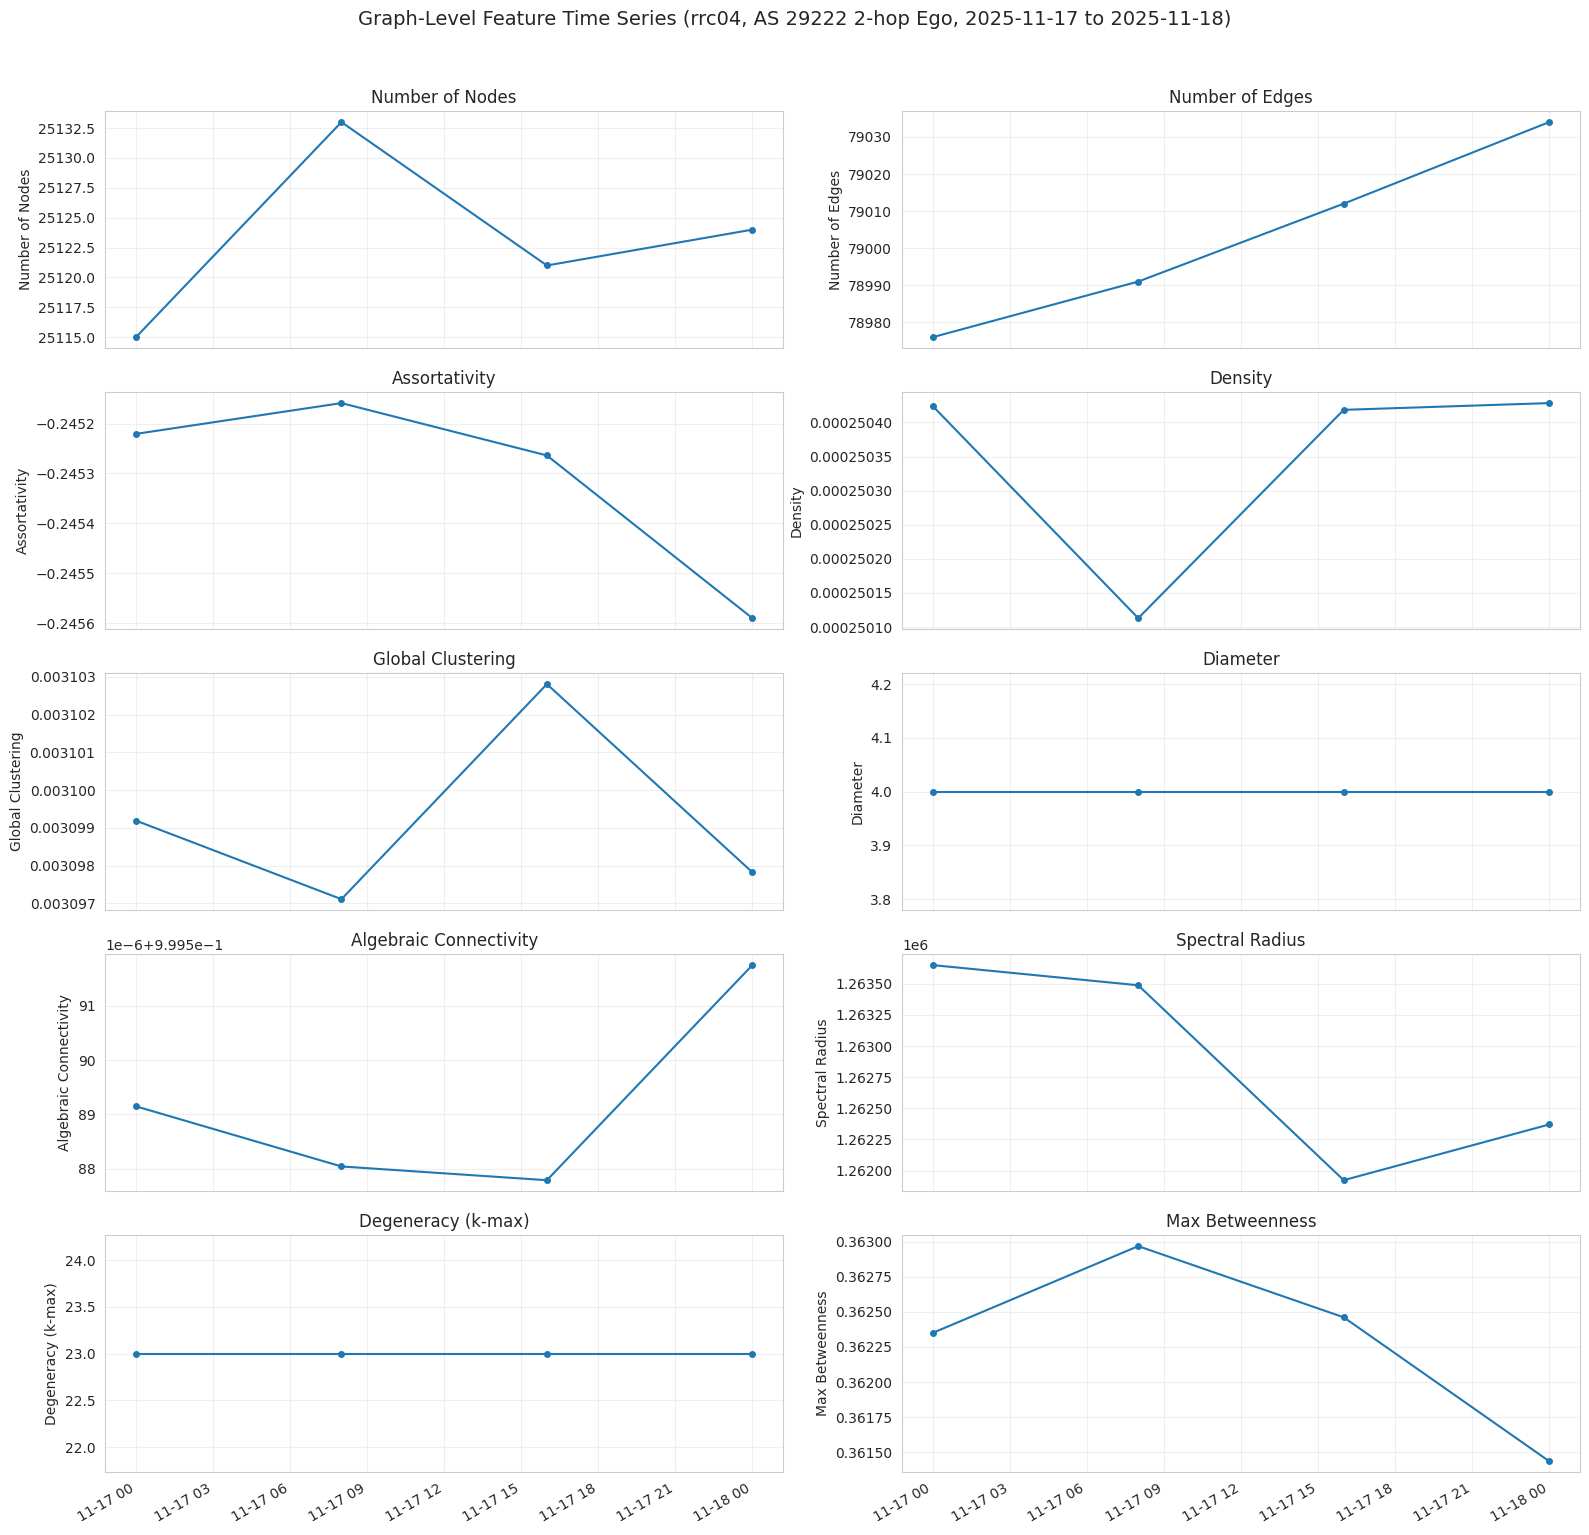

Saved: /home/smotaali/First_Full_Paper/bgp_graph_features_results/figures/graph_features_timeseries_rrc04_AS29222_2hop_2025-11-17_2025-11-18.png


In [ ]:
# ============================================================================
# Visualization: Graph-level feature time series
# ============================================================================

title_suffix = f"AS {TARGET_AS} {EGO_K_HOP}-hop Ego" if TARGET_AS else "Full Graph"

key_features = [
    ('n_nodes', 'Number of Nodes'),
    ('n_edges', 'Number of Edges'),
    ('assortativity', 'Assortativity'),
    ('density', 'Density'),
    ('clustering_global', 'Global Clustering'),
    ('diameter', 'Diameter'),
    ('algebraic_connectivity', 'Algebraic Connectivity'),
    ('spectral_radius', 'Spectral Radius'),
    ('degeneracy', 'Degeneracy (k-max)'),
    ('betweenness_max', 'Max Betweenness'),
]

n_plots = len(key_features)
n_cols = 2
n_rows = (n_plots + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows), sharex=True)
axes = axes.flatten()

for i, (feat, label) in enumerate(key_features):
    ax = axes[i]
    if feat in graph_ts_df.columns:
        vals = graph_ts_df[feat].dropna()
        ts = graph_ts_df.loc[vals.index, 'timestamp']
        ax.plot(ts, vals, 'o-', markersize=4, linewidth=1.5)
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)
    else:
        ax.set_visible(False)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.autofmt_xdate()
plt.suptitle(f'Graph-Level Feature Time Series ({COLLECTOR}, {title_suffix}, {START_DATE} to {END_DATE})',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'graph_features_timeseries_{suffix}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / f'graph_features_timeseries_{suffix}.png'}")

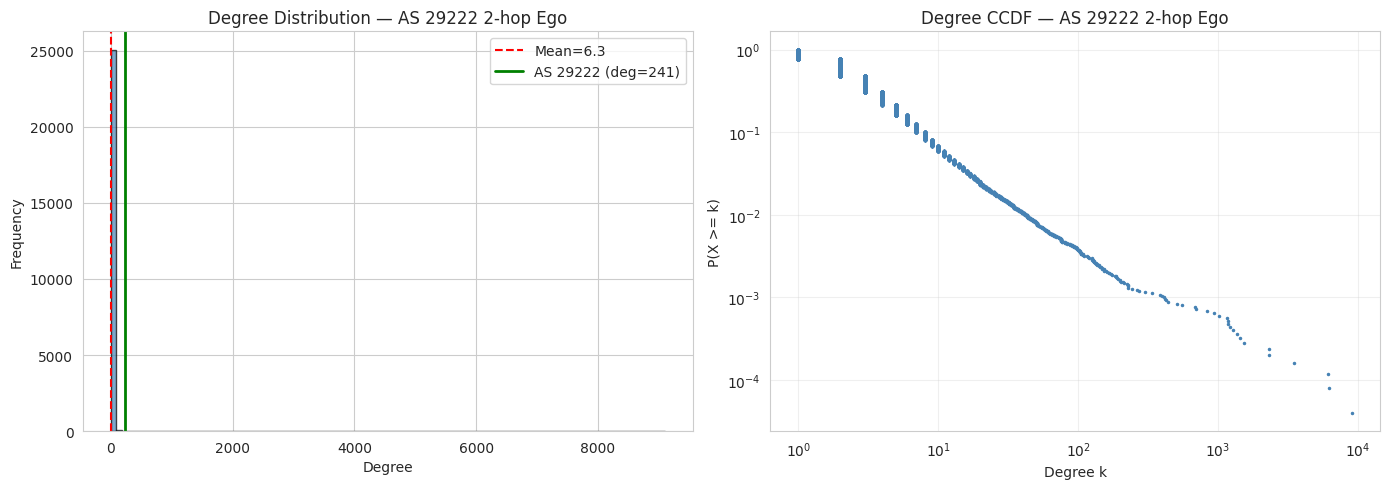

Saved: /home/smotaali/First_Full_Paper/bgp_graph_features_results/figures/degree_distribution_rrc04_AS29222_2hop_2025-11-17_2025-11-18.png


In [ ]:
# ============================================================================
# Visualization: Degree Distribution (last snapshot)
# ============================================================================

if len(node_level_rows) > 0:
    last_snap = node_ts_df[node_ts_df['snapshot_id'] == graph_ts_df.iloc[-1]['snapshot_id']]
    degrees_last = last_snap['degree'].dropna().values

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Linear histogram
    axes[0].hist(degrees_last, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Degree Distribution — {title_suffix}')
    axes[0].axvline(x=np.mean(degrees_last), color='red', linestyle='--',
                    label=f'Mean={np.mean(degrees_last):.1f}')
    axes[0].legend()

    # Highlight target AS if in ego mode
    if TARGET_AS and TARGET_AS in last_snap['asn'].values:
        target_deg = last_snap.loc[last_snap['asn'] == TARGET_AS, 'degree'].iloc[0]
        axes[0].axvline(x=target_deg, color='green', linestyle='-', linewidth=2,
                        label=f'AS {TARGET_AS} (deg={int(target_deg)})')
        axes[0].legend()

    # Log-log CCDF
    sorted_deg = np.sort(degrees_last)[::-1]
    ccdf = np.arange(1, len(sorted_deg) + 1) / len(sorted_deg)
    axes[1].loglog(sorted_deg, ccdf, '.', markersize=3, color='steelblue')
    axes[1].set_xlabel('Degree k')
    axes[1].set_ylabel('P(X >= k)')
    axes[1].set_title(f'Degree CCDF — {title_suffix}')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'degree_distribution_{suffix}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {FIGURES_DIR / f'degree_distribution_{suffix}.png'}")

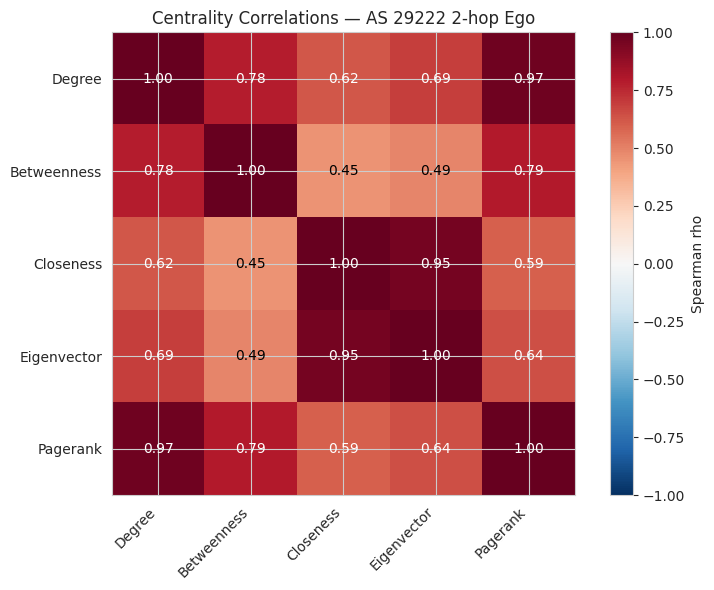

Saved: /home/smotaali/First_Full_Paper/bgp_graph_features_results/figures/centrality_correlations_rrc04_AS29222_2hop_2025-11-17_2025-11-18.png

Target AS 29222 — Feature Summary (last snapshot):
  degree_centrality                  0.009593  (rank 32/25124)
  degree                           241.000000  (rank 32/25124)
  betweenness_centrality             0.006148  (rank 28/25124)
  closeness_centrality               0.502410  (rank 7/25124)
  eigenvector_centrality             0.035841  (rank 21/25124)
  pagerank                           0.001176  (rank 41/25124)
  local_clustering                   0.058402  (rank 15719/25124)
  avg_neighbor_degree              201.128631  (rank 22873/25124)
  node_clique_number                10.000000  (rank 49/25124)
  eccentricity                       2.000000  (rank 25124/25124)
  core_number                       22.000000  (rank 66/25124)


In [ ]:
# ============================================================================
# Visualization: Centrality Correlations (last snapshot)
# ============================================================================

if len(node_level_rows) > 0:
    last_snap = node_ts_df[node_ts_df['snapshot_id'] == graph_ts_df.iloc[-1]['snapshot_id']]
    centrality_cols = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality',
                       'eigenvector_centrality', 'pagerank']
    existing_cols = [c for c in centrality_cols if c in last_snap.columns]

    if len(existing_cols) >= 2:
        fig, ax = plt.subplots(figsize=(8, 6))
        corr = last_snap[existing_cols].corr(method='spearman')
        im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(existing_cols)))
        ax.set_yticks(range(len(existing_cols)))
        short_names = [c.replace('_centrality', '').replace('_', ' ').title() for c in existing_cols]
        ax.set_xticklabels(short_names, rotation=45, ha='right')
        ax.set_yticklabels(short_names)

        for i_r in range(len(existing_cols)):
            for j_r in range(len(existing_cols)):
                ax.text(j_r, i_r, f"{corr.iloc[i_r, j_r]:.2f}", ha='center', va='center',
                        color='white' if abs(corr.iloc[i_r, j_r]) > 0.5 else 'black', fontsize=10)

        plt.colorbar(im, label='Spearman rho')
        ax.set_title(f'Centrality Correlations — {title_suffix}')
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / f'centrality_correlations_{suffix}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {FIGURES_DIR / f'centrality_correlations_{suffix}.png'}")

    # --- Target AS feature summary ---
    if TARGET_AS:
        target_row = last_snap[last_snap['asn'] == TARGET_AS]
        if not target_row.empty:
            print(f"\nTarget AS {TARGET_AS} — Feature Summary (last snapshot):")
            feature_cols = [c for c in last_snap.columns
                          if c not in ['asn', 'snapshot_id', 'timestamp']]
            for col in feature_cols:
                val = target_row[col].iloc[0]
                if pd.notna(val):
                    # Show rank within ego network
                    rank = (last_snap[col].dropna() >= val).sum()
                    total = last_snap[col].dropna().shape[0]
                    print(f"  {col:<30} {val:>12.6f}  (rank {rank}/{total})")

## Feature Definitions Reference

**Note:** All features below are computed on the **ego subgraph** (k-hop neighborhood
of the target AS), not the full global AS graph. This means:
- Graph-level features describe the **local topology** around the target AS
- Node-level features are computed for the target AS **and all its k-hop neighbors**
- Changes in these features over time indicate **local topology anomalies**

### Graph-Level Features (16)

| # | Feature | Definition | Ego Interpretation | Citation |
|---|---------|------------|--------------------|----------|
| 1 | **Assortativity** | Pearson correlation of degrees at edge endpoints | Do high-degree nodes in the neighborhood connect to each other? | Newman (2002) |
| 2 | **Density** | 2\|E\| / [\|V\|(\|V\|-1)] | How interconnected is the local neighborhood? | Standard |
| 3 | **Clustering** | 3 x triangles / connected triples | Do the target's peers form triangles with each other? | Watts & Strogatz (1998) |
| 4 | **Diameter** | max d(u,v) in ego subgraph | How "wide" is the local neighborhood? | Watts & Strogatz (1998) |
| 5 | **Algebraic connectivity** | 2nd smallest Laplacian eigenvalue | How robust is the local neighborhood to splits? | Fiedler (1973) |
| 6 | **Spectral radius** | Largest adjacency eigenvalue | Concentration of connectivity in the neighborhood | Cvetkovic et al. (2010) |
| 7 | **Percolation limit** | 1/spectral_radius | Epidemic threshold in the local network | Pastor-Satorras & Vespignani (2001) |
| 8 | **Symmetry ratio** | \|distinct eigenvalues\| / (D+1) | Structural regularity of the neighborhood | Dekker (2005) |
| 9 | **Natural connectivity** | ln[(1/n) sum exp(eigenvalues)] | Redundancy / fault tolerance of neighborhood | Wu et al. (2011) |
| 10 | **Kirchhoff index** | n sum(1/laplacian_eigs) | Effective resistance of the neighborhood | Klein & Randic (1993) |
| 11 | **log(Spanning trees)** | Matrix tree theorem | Path diversity in the local network | Kirchhoff (1847) |
| 12 | **Edge/node connectivity** | Min cut size | Minimum links to disconnect the neighborhood | Whitney (1932) |
| 13 | **Rich-club coefficient** | phi(k) at degree percentiles | Do high-degree neighbors preferentially connect? | Zhou & Mondragon (2004) |
| 14 | **Betweenness distribution** | Mean, max, std, skewness | Traffic concentration in the neighborhood | Brandes (2001) |
| 15 | **k-Core metrics** | Degeneracy, core distribution | Depth of hierarchical structure | Seidman (1983) |
| 16 | **Spectral gap** | lambda_1 - lambda_2 | Expansion properties of the neighborhood | Chung (1997) |

### Node-Level Features (10)

| # | Feature | Definition | Citation |
|---|---------|------------|----------|
| 1 | **Degree centrality** | deg(v)/(n-1) | Freeman (1979) |
| 2 | **Betweenness centrality** | Sum of shortest path fractions through v | Brandes (2001) |
| 3 | **Closeness centrality** | (n-1) / sum of distances from v | Sabidussi (1966) |
| 4 | **Eigenvector centrality** | Principal eigenvector of A | Bonacich (1972) |
| 5 | **PageRank** | Stationary random walk distribution (d=0.85) | Brin & Page (1998) |
| 6 | **Local clustering** | 2 x triangles(v) / [d(d-1)] | Watts & Strogatz (1998) |
| 7 | **Avg neighbor degree** | (1/d) sum of neighbor degrees | Pastor-Satorras et al. (2001) |
| 8 | **Node clique number** | Max clique containing v | NP-hard (Karp, 1972) |
| 9 | **Eccentricity** | max distance from v | Standard |
| 10 | **Core number (k-shell)** | max{k : v in H_k} | Seidman (1983) |

In [ ]:
# ============================================================================
# PIPELINE COMPLETE
# ============================================================================

print("\n" + "=" * 70)
print("PIPELINE COMPLETE")
print("=" * 70)
print(f"\nCollector: {COLLECTOR}")
print(f"Date range: {START_DATE} to {END_DATE}")
if TARGET_AS:
    print(f"Mode: Ego-network (AS {TARGET_AS}, {EGO_K_HOP}-hop)")
else:
    print(f"Mode: Full graph")
print(f"Snapshots processed: {len(graph_level_rows)}/{len(snapshot_manifest)}")
if snapshot_errors:
    print(f"Snapshot errors: {len(snapshot_errors)}")
print(f"\nGraph-level time series: {graph_ts_df.shape}")
print(f"Node-level time series: {node_ts_df.shape}")
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

# Quick verification
assert len(graph_ts_df) > 0, "No snapshots processed"
assert 'snapshot_id' in graph_ts_df.columns
assert 'timestamp' in graph_ts_df.columns
assert 'algebraic_connectivity' in graph_ts_df.columns

for snap_id_v in graph_ts_df['snapshot_id']:
    n_expected = graph_ts_df.loc[graph_ts_df['snapshot_id'] == snap_id_v, 'n_nodes'].iloc[0]
    n_actual = len(node_ts_df[node_ts_df['snapshot_id'] == snap_id_v])
    assert n_actual == n_expected, f"Node count mismatch for {snap_id_v}: {n_actual} vs {n_expected}"

print("\nAll verification checks passed.")


PIPELINE COMPLETE

Collector: rrc04
Date range: 2025-11-17 to 2025-11-18
Mode: Ego-network (AS 29222, 2-hop)
Snapshots processed: 4/4

Graph-level time series: (4, 50)
Node-level time series: (100493, 14)

Output directory: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output
Figures directory: /home/smotaali/First_Full_Paper/bgp_graph_features_results/figures

All verification checks passed.


In [ ]:
# ============================================================================
# EXPORT AS GRAPHS (1-HOP & 2-HOP) FOR ALL SNAPSHOTS — GEXF FOR GEPHI
# ============================================================================

GEXF_DIR = OUTPUT_DIR / "gexf"
GEXF_DIR.mkdir(parents=True, exist_ok=True)

def attach_node_attributes(G_export, snap_id, hop_label):
    """Attach node-level features from node_ts_df as graph attributes."""
    snap_nodes = node_ts_df[node_ts_df['snapshot_id'] == snap_id].set_index('asn')
    attr_cols = [c for c in snap_nodes.columns if c not in ('snapshot_id', 'timestamp')]
    for node in G_export.nodes():
        if node in snap_nodes.index:
            for col in attr_cols:
                val = snap_nodes.loc[node, col]
                G_export.nodes[node][col] = float(val) if not isinstance(val, str) else val
    # Mark target AS
    if TARGET_AS and TARGET_AS in G_export.nodes():
        G_export.nodes[TARGET_AS]['is_target'] = 1
    # Compute hop distance from target
    if TARGET_AS and TARGET_AS in G_export.nodes():
        hop_dist = nx.single_source_shortest_path_length(G_export, TARGET_AS)
        for node, dist in hop_dist.items():
            G_export.nodes[node]['hop_from_target'] = dist

export_counts = {'1hop': 0, '2hop': 0}

for idx, snap in enumerate(snapshot_manifest):
    snap_id = snap['snapshot_id']
    snap_csv = snap['csv_path']

    print(f"[{idx+1}/{len(snapshot_manifest)}] {snap_id} ... ", end="", flush=True)

    try:
        edges, edge_counts = build_edges_from_csv(snap_csv)
        if len(edges) == 0:
            print("SKIP (no edges)")
            continue

        # Build the full graph
        G_full = nx.Graph()
        for (u, v), w in edge_counts.items():
            G_full.add_edge(u, v, weight=w)

        if TARGET_AS not in G_full:
            print(f"SKIP (AS {TARGET_AS} not in graph)")
            del G_full
            continue

        # --- 1-hop graph (direct peers only) ---
        G_1hop, _ = extract_ego_subgraph(G_full, TARGET_AS, k_hop=1)
        if G_1hop is not None:
            attach_node_attributes(G_1hop, snap_id, '1hop')
            path_1 = GEXF_DIR / f"as_graph_{COLLECTOR}_AS{TARGET_AS}_1hop_{snap_id}.gexf"
            nx.write_gexf(G_1hop, str(path_1))
            export_counts['1hop'] += 1

        # --- 2-hop graph (full ego-network) ---
        G_2hop, _ = extract_ego_subgraph(G_full, TARGET_AS, k_hop=2)
        if G_2hop is not None:
            attach_node_attributes(G_2hop, snap_id, '2hop')
            path_2 = GEXF_DIR / f"as_graph_{COLLECTOR}_AS{TARGET_AS}_2hop_{snap_id}.gexf"
            nx.write_gexf(G_2hop, str(path_2))
            export_counts['2hop'] += 1

        n1 = G_1hop.number_of_nodes() if G_1hop else 0
        n2 = G_2hop.number_of_nodes() if G_2hop else 0
        print(f"1-hop: {n1:,} nodes | 2-hop: {n2:,} nodes")

        del G_full, G_1hop, G_2hop

    except Exception as e:
        print(f"ERROR: {e}")


[1/4] rrc04_20251117_0000 ... 1-hop: 244 nodes | 2-hop: 25,115 nodes
[2/4] rrc04_20251117_0800 ... 1-hop: 244 nodes | 2-hop: 25,133 nodes
[3/4] rrc04_20251117_1600 ... 1-hop: 243 nodes | 2-hop: 25,121 nodes
[4/4] rrc04_20251118_0000 ... 1-hop: 242 nodes | 2-hop: 25,124 nodes


In [ ]:
# HTML template for the interactive topology visualization
# (auto-generated, do not edit manually)

HTML_VIZ_TEMPLATE = r'''<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>BGP AS-Level Topology — {{COLLECTOR}} {{SNAPSHOT_ID}}</title>
<style>
@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono:wght@300;400;500;600;700;800&family=Outfit:wght@300;400;500;600;700;800;900&display=swap');
:root{--bg:#06080f;--glass:rgba(10,14,28,0.82);--text:#e2e8f0;--t2:#94a3b8;--t3:#64748b;--brd:rgba(100,116,139,0.1);--brd2:rgba(100,116,139,0.18);--accent1:#06b6d4;--accent2:#a78bfa;--accent3:#f472b6;--warn:#fbbf24;--ok:#34d399}
*{margin:0;padding:0;box-sizing:border-box}
body{font-family:'Outfit',system-ui,sans-serif;background:var(--bg);color:var(--text);height:100vh;overflow:hidden;display:flex;flex-direction:column}
.hdr{height:50px;background:var(--glass);backdrop-filter:blur(24px);border-bottom:1px solid var(--brd2);display:flex;align-items:center;padding:0 20px;gap:16px;z-index:100;flex-shrink:0;position:relative}
.hdr::after{content:'';position:absolute;bottom:0;left:0;right:0;height:1px;background:linear-gradient(90deg,transparent,rgba(6,182,212,0.25),rgba(167,139,250,0.25),transparent)}
.hdr h1{font-size:13px;font-weight:800;letter-spacing:.3px;background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent}
.hdr .tag{font-size:9px;padding:3px 8px;border-radius:5px;background:rgba(6,182,212,0.08);border:1px solid rgba(6,182,212,0.2);color:var(--accent1);font-weight:600;font-family:'JetBrains Mono',monospace}
.hdr .stats{display:flex;gap:16px;font-size:10px;color:var(--t2);margin-left:auto;font-weight:500}
.hdr .stats b{background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent;font-weight:700}
.btn{padding:5px 14px;border-radius:6px;background:var(--glass);color:var(--text);font-size:10px;font-weight:600;border:1px solid var(--brd2);cursor:pointer;display:inline-flex;align-items:center;gap:5px;transition:all .2s;font-family:'Outfit',sans-serif}
.btn:hover{background:rgba(255,255,255,0.06);border-color:rgba(6,182,212,0.3)}
.filters{height:38px;background:rgba(10,14,28,0.5);border-bottom:1px solid var(--brd);display:flex;align-items:center;padding:0 20px;gap:8px;flex-shrink:0;z-index:50}
.filters label{font-size:8px;color:var(--t3);font-weight:700;letter-spacing:.8px;text-transform:uppercase}
.ft{padding:3px 11px;border-radius:14px;font-size:9px;cursor:pointer;border:1px solid var(--brd2);background:transparent;color:var(--t2);transition:all .2s;font-weight:600;font-family:'Outfit',sans-serif}
.ft.on{background:rgba(6,182,212,0.1);border-color:rgba(6,182,212,0.4);color:var(--accent1)}
#searchBox{background:rgba(255,255,255,0.04);border:1px solid var(--brd2);border-radius:6px;padding:4px 12px;color:var(--text);font-size:10px;width:200px;outline:none;font-family:'JetBrains Mono',monospace}
#searchBox:focus{border-color:rgba(6,182,212,0.4)}
#searchBox::placeholder{color:var(--t3)}
.main{flex:1;display:flex;overflow:hidden;position:relative;z-index:1}
#canvasWrap{flex:1;position:relative;overflow:hidden;cursor:grab}
#canvasWrap.grabbing{cursor:grabbing}
canvas{display:block;width:100%;height:100%}
#tooltip{position:absolute;pointer-events:none;background:rgba(6,8,15,0.96);backdrop-filter:blur(20px);border:1px solid var(--brd2);border-radius:10px;padding:10px 14px;font-size:10px;color:var(--text);z-index:200;opacity:0;transition:opacity .12s;max-width:300px;box-shadow:0 12px 32px rgba(0,0,0,0.6)}
#tooltip.show{opacity:1}
#tooltip .tt-asn{font-size:13px;font-weight:800;background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent}
#tooltip .tt-tier{font-size:8px;display:inline-block;padding:2px 6px;border-radius:4px;font-weight:700;margin-left:6px}
#tooltip .tt-grid{display:grid;grid-template-columns:1fr 1fr;gap:3px 12px;margin-top:6px;font-size:9px;font-family:'JetBrains Mono',monospace}
#tooltip .tt-grid .tl{color:var(--t3);font-weight:500}
#tooltip .tt-grid .tv{color:var(--accent1);font-weight:600}
.legend{position:absolute;bottom:14px;left:14px;background:rgba(6,8,15,0.9);backdrop-filter:blur(20px);border:1px solid var(--brd2);border-radius:12px;padding:12px 16px;font-size:9px;z-index:50;min-width:160px}
.legend .lt{font-weight:800;margin-bottom:8px;font-size:10px;background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent}
.legend .lr{display:flex;align-items:center;gap:7px;margin-bottom:5px;color:var(--t2)}
.legend .ld{width:10px;height:10px;border-radius:50%}
.legend .ll{width:20px;height:2px;border-radius:1px}
.legend .lsep{height:1px;background:var(--brd);margin:6px 0}
.legend .lh{font-size:7px;color:var(--t3);margin-top:4px;line-height:1.5}
#panel{width:0;overflow:hidden;background:rgba(6,8,15,0.94);backdrop-filter:blur(24px);border-left:1px solid var(--brd2);transition:width .35s cubic-bezier(.25,.8,.25,1);flex-shrink:0;display:flex;flex-direction:column}
#panel.open{width:400px}
.ph{padding:14px 16px;border-bottom:1px solid var(--brd);display:flex;align-items:center;gap:10px;flex-shrink:0}
.ph h2{font-size:14px;flex:1;font-weight:800;font-family:'JetBrains Mono',monospace}
.ph .badge{font-size:8px;padding:2px 8px;border-radius:4px;font-weight:700}
.pcl{width:26px;height:26px;border-radius:6px;border:1px solid var(--brd2);background:transparent;color:var(--t3);cursor:pointer;display:flex;align-items:center;justify-content:center;font-size:15px;transition:all .2s;font-family:'Outfit',sans-serif}
.pcl:hover{background:rgba(244,63,94,0.12);color:#f472b6}
.ptabs{display:flex;border-bottom:1px solid var(--brd);flex-shrink:0;background:rgba(0,0,0,0.2)}
.ptab{flex:1;padding:9px;text-align:center;font-size:9px;cursor:pointer;color:var(--t3);border-bottom:2px solid transparent;font-weight:700;transition:all .2s}
.ptab.on{color:var(--accent1);border-bottom-color:var(--accent1)}
.pbody{flex:1;overflow-y:auto;padding:14px 16px}
.sc{background:rgba(255,255,255,0.015);border:1px solid var(--brd);border-radius:10px;padding:12px;margin-bottom:10px}
.st{font-size:10px;font-weight:800;margin-bottom:8px;background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent}
.metric-grid{display:grid;grid-template-columns:1fr 1fr 1fr;gap:6px;margin-bottom:10px}
.metric{background:rgba(255,255,255,0.02);border:1px solid var(--brd);border-radius:8px;padding:8px;text-align:center}
.metric .mv{font-size:16px;font-weight:800;font-family:'JetBrains Mono',monospace}
.metric .ml{font-size:7px;color:var(--t3);margin-top:2px;font-weight:600;text-transform:uppercase;letter-spacing:.5px}
.feat-row{display:flex;justify-content:space-between;align-items:center;padding:4px 0;font-size:9px;border-bottom:1px solid rgba(100,116,139,0.06)}
.feat-row .fl{color:var(--t2)}
.feat-row .fv{font-family:'JetBrains Mono',monospace;color:var(--accent1);font-weight:600}
.nb-item{display:flex;align-items:center;gap:8px;padding:5px 6px;border-radius:6px;cursor:pointer;transition:background .15s;font-size:9px}
.nb-item:hover{background:rgba(255,255,255,0.03)}
.nb-dot{width:8px;height:8px;border-radius:50%;flex-shrink:0}
.nb-asn{font-family:'JetBrains Mono',monospace;font-weight:600;min-width:65px}
.nb-w{font-size:8px;color:var(--t3);margin-left:auto;font-family:'JetBrains Mono',monospace}
.load{position:absolute;inset:0;display:flex;align-items:center;justify-content:center;background:var(--bg);z-index:200;flex-direction:column;gap:12px}
.load .sp{width:40px;height:40px;border:2px solid var(--brd);border-top-color:var(--accent1);border-radius:50%;animation:spin .7s linear infinite}
.load span{font-size:11px;color:var(--t3);font-weight:500}
@keyframes spin{to{transform:rotate(360deg)}}
::-webkit-scrollbar{width:3px}::-webkit-scrollbar-track{background:transparent}::-webkit-scrollbar-thumb{background:rgba(148,163,184,0.12);border-radius:3px}
</style>
</head>
<body>
<div class="hdr">
    <h1>BGP AS-Level Topology</h1>
    <span class="tag">{{COLLECTOR}} · {{SNAPSHOT_TS}}</span>
    <div class="stats">
        <span>ASes: <b id="sN">0</b></span>
        <span>Links: <b id="sE">0</b></span>
        <span>Target: <b id="sT">—</b></span>
        <span>Degeneracy: <b id="sK">—</b></span>
    </div>
    <button class="btn" onclick="resetAll()">↻ Reset</button>
    <button class="btn" onclick="exportSVG()">⬇ SVG</button>
</div>
<div class="filters">
    <label>Tier:</label>
    <button class="ft on" data-f="all" onclick="setF('all',this)">All</button>
    <button class="ft" data-f="core" onclick="setF('core',this)">Core / Tier-1</button>
    <button class="ft" data-f="transit" onclick="setF('transit',this)">Transit</button>
    <button class="ft" data-f="edge" onclick="setF('edge',this)">Edge / Stub</button>
    <span style="width:1px;height:20px;background:var(--brd2);margin:0 8px"></span>
    <label>Show:</label>
    <button class="ft on" id="btnLabels" onclick="toggleLabels(this)">Labels</button>
    <button class="ft on" id="btnParticles" onclick="toggleParticles(this)">Particles</button>
    <span style="flex:1"></span>
    <input id="searchBox" placeholder="Search AS number…" oninput="doSearch(this.value)">
</div>
<div class="main">
<div id="canvasWrap">
    <canvas id="graphCanvas"></canvas>
    <div id="tooltip"></div>
    <div class="legend">
        <div class="lt">AS TIERS</div>
        <div class="lr"><div class="ld" style="background:linear-gradient(135deg,#f472b6,#fb923c);box-shadow:0 0 6px #f472b6"></div>Core (innermost k-shell)</div>
        <div class="lr"><div class="ld" style="background:linear-gradient(135deg,#a78bfa,#818cf8);box-shadow:0 0 6px #a78bfa"></div>Transit (high k-shell)</div>
        <div class="lr"><div class="ld" style="background:linear-gradient(135deg,#06b6d4,#3b82f6);box-shadow:0 0 6px #06b6d4"></div>Edge / Stub</div>
        <div class="lr"><div class="ld" style="background:linear-gradient(135deg,#fbbf24,#f97316);box-shadow:0 0 8px #fbbf24"></div><b>Target AS</b></div>
        <div class="lsep"></div>
        <div class="lt">LINKS</div>
        <div class="lr"><div class="ll" style="background:#f472b6"></div>Core ↔ Core</div>
        <div class="lr"><div class="ll" style="background:#a78bfa"></div>Core ↔ Transit</div>
        <div class="lr"><div class="ll" style="background:#06b6d4"></div>Transit ↔ Edge</div>
        <div class="lr"><div class="ll" style="background:#475569"></div>Edge ↔ Edge</div>
        <div class="lsep"></div>
        <div class="lh">Click: Select · DblClick: Details<br>Scroll: Zoom · Drag: Pan</div>
    </div>
    <div class="load" id="loader"><div class="sp"></div><span>Building layout…</span></div>
</div>
<div id="panel">
    <div class="ph"><h2 id="pTitle">—</h2><span class="badge" id="pBadge">—</span><button class="pcl" onclick="closeP()">×</button></div>
    <div class="ptabs">
        <div class="ptab on" data-t="ov" onclick="tab('ov',this)">Overview</div>
        <div class="ptab" data-t="cent" onclick="tab('cent',this)">Centrality</div>
        <div class="ptab" data-t="nb" onclick="tab('nb',this)">Neighbors</div>
    </div>
    <div class="pbody">
        <div id="t-ov" class="tc-on"></div>
        <div id="t-cent" style="display:none"></div>
        <div id="t-nb" style="display:none"></div>
    </div>
</div>
</div>

<script>
// ── DATA (injected by notebook) ──
const DATA = {{DATA_JSON}};

const canvas = document.getElementById('graphCanvas');
const ctx = canvas.getContext('2d');
const wrap = document.getElementById('canvasWrap');
const ttip = document.getElementById('tooltip');

let W, H, dpr;
let nodes = [], links = [], nodeMap = {};
let selected = null, hovered = null, filter = 'all', searchStr = '';
let showLabels = true, showParticles = true;
let cam = {x:0, y:0, z:1}, tCam = {x:0, y:0, z:1};
let particles = [], dragging = false, dragS = {x:0,y:0}, camS = {x:0,y:0};

const TARGET_AS = DATA.target_as;
const DEGENERACY = DATA.degeneracy;

// Tier classification based on core number
function getTier(n) {
    if (n.asn === TARGET_AS) return 'target';
    if (n.core_number >= DEGENERACY) return 'core';
    if (n.core_number >= DEGENERACY * 0.5) return 'transit';
    return 'edge';
}

const TIER_PAL = {
    target: {c:['#fbbf24','#f97316'], g:'#fbbf24', base_r: 22},
    core:   {c:['#f472b6','#fb923c'], g:'#f472b6', base_r: 16},
    transit:{c:['#a78bfa','#818cf8'], g:'#a78bfa', base_r: 12},
    edge:   {c:['#06b6d4','#3b82f6'], g:'#06b6d4', base_r: 8}
};

const TIER_BADGE = {
    target: {label:'TARGET', bg:'linear-gradient(135deg,rgba(251,191,36,0.2),rgba(249,115,22,0.2))', color:'#fbbf24', border:'rgba(251,191,36,0.3)'},
    core:   {label:'CORE',   bg:'linear-gradient(135deg,rgba(244,114,182,0.2),rgba(251,146,60,0.2))', color:'#f472b6', border:'rgba(244,114,182,0.3)'},
    transit:{label:'TRANSIT', bg:'linear-gradient(135deg,rgba(167,139,250,0.2),rgba(129,140,248,0.2))', color:'#c4b5fd', border:'rgba(167,139,250,0.3)'},
    edge:   {label:'EDGE',    bg:'linear-gradient(135deg,rgba(6,182,212,0.2),rgba(59,130,246,0.2))', color:'#67e8f9', border:'rgba(6,182,212,0.3)'}
};

function linkColor(l) {
    const st = l.sn.tier, tt = l.tn.tier;
    if ((st==='core'||st==='target') && (tt==='core'||tt==='target')) return '#f472b6';
    if (st==='core'||tt==='core'||st==='target'||tt==='target') return '#a78bfa';
    if (st==='transit'||tt==='transit') return '#06b6d4';
    return '#475569';
}

function hex2(h,a){return`rgba(${parseInt(h.slice(1,3),16)},${parseInt(h.slice(3,5),16)},${parseInt(h.slice(5,7),16)},${a})`;}

// ── LAYOUT: Force-directed ──
function forceLayout(requestedIters) {
    const iters = nodes.length > 1000 ? Math.min(requestedIters, 60) : requestedIters;
    const n = nodes.length;
    if (n === 0) return;
    // Initial placement: arrange by tier in concentric rings
    const cx = 0, cy = 0;
    const coreN = nodes.filter(d=>d.tier==='core'||d.tier==='target');
    const transN = nodes.filter(d=>d.tier==='transit');
    const edgeN = nodes.filter(d=>d.tier==='edge');

    function placeRing(arr, r, jitter) {
        arr.forEach((nd, i) => {
            const a = (2*Math.PI*i)/arr.length + (Math.random()-0.5)*jitter;
            nd.wx = cx + r * Math.cos(a);
            nd.wy = cy + r * Math.sin(a);
        });
    }
    // Target at center
    const tgt = nodes.find(d=>d.asn===TARGET_AS);
    if (tgt) { tgt.wx = cx; tgt.wy = cy; }

    placeRing(coreN.filter(d=>d.asn!==TARGET_AS), 300, 0.3);
    placeRing(transN, 700, 0.5);
    placeRing(edgeN, 1200, 0.8);

    // Force simulation
    const area = Math.max(2000, Math.sqrt(n) * 200);
    const k = area / Math.sqrt(n);
    const kSq = k * k;

    for (let iter = 0; iter < iters; iter++) {
        const temp = 0.3 * (1 - iter/iters);
        const dx = new Float64Array(n), dy = new Float64Array(n);

        // Repulsion (Barnes-Hut approximation for speed: use grid)
        for (let i = 0; i < n; i++) {
            for (let j = i+1; j < n; j++) {
                let ddx = nodes[j].wx - nodes[i].wx;
                let ddy = nodes[j].wy - nodes[i].wy;
                let d2 = ddx*ddx + ddy*ddy;
                if (d2 < 1) d2 = 1;
                let d = Math.sqrt(d2);
                let f = kSq / d2;
                let fx = ddx/d * f, fy = ddy/d * f;
                dx[i] -= fx; dy[i] -= fy;
                dx[j] += fx; dy[j] += fy;
            }
        }

        // Attraction along edges
        for (const l of links) {
            const si = l.si, ti = l.ti;
            let ddx = nodes[ti].wx - nodes[si].wx;
            let ddy = nodes[ti].wy - nodes[si].wy;
            let d = Math.sqrt(ddx*ddx + ddy*ddy);
            if (d < 1) d = 1;
            let f = d / k * 0.3;
            let fx = ddx/d * f, fy = ddy/d * f;
            dx[si] += fx; dy[si] += fy;
            dx[ti] -= fx; dy[ti] -= fy;
        }

        // Gravity toward center
        for (let i = 0; i < n; i++) {
            let ddx = -nodes[i].wx;
            let ddy = -nodes[i].wy;
            let d = Math.sqrt(ddx*ddx + ddy*ddy);
            if (d > 1) {
                let gf = 0.5 * d / k;
                dx[i] += ddx/d * gf;
                dy[i] += ddy/d * gf;
            }
        }

        // Apply
        for (let i = 0; i < n; i++) {
            let d = Math.sqrt(dx[i]*dx[i] + dy[i]*dy[i]);
            if (d > 0) {
                let cap = Math.min(d, k * temp);
                nodes[i].wx += dx[i]/d * cap;
                nodes[i].wy += dy[i]/d * cap;
            }
        }
    }

    // Anti-overlap pass
    const minDist = 60;
    for (let pass = 0; pass < 15; pass++) {
        for (let i = 0; i < n; i++) {
            for (let j = i+1; j < n; j++) {
                const ddx = nodes[j].wx - nodes[i].wx, ddy = nodes[j].wy - nodes[i].wy;
                const d = Math.sqrt(ddx*ddx + ddy*ddy);
                if (d < minDist && d > 0.1) {
                    const push = (minDist - d) / 2 * 0.3;
                    const nx = ddx/d * push, ny = ddy/d * push;
                    nodes[j].wx += nx; nodes[j].wy += ny;
                    nodes[i].wx -= nx; nodes[i].wy -= ny;
                }
            }
        }
    }
}

// ── BUILD ──
function buildGraph() {
    nodes = DATA.nodes.map((n, i) => {
        const tier = getTier(n);
        const pal = n.asn === TARGET_AS ? TIER_PAL.target : TIER_PAL[tier];
        const degScale = Math.min(2, Math.max(0.6, Math.log2(n.degree + 1) / 4));
        return {...n, idx: i, tier, pal, r: pal.base_r * degScale, wx: 0, wy: 0, pulse: Math.random()*Math.PI*2};
    });
    nodeMap = {};
    nodes.forEach(n => nodeMap[n.asn] = n);

    links = DATA.links.map(l => ({
        ...l, sn: nodeMap[l.source], tn: nodeMap[l.target],
        si: nodeMap[l.source]?.idx, ti: nodeMap[l.target]?.idx
    })).filter(l => l.sn && l.tn);

    document.getElementById('sN').textContent = nodes.length;
    document.getElementById('sE').textContent = links.length;
    document.getElementById('sT').textContent = TARGET_AS || '—';
    document.getElementById('sK').textContent = DEGENERACY || '—';
}

function mkParticles() {
    particles = [];
    if (!showParticles) return;
    links.forEach((l,i) => {
        const tier = Math.max(
            ['edge','transit','core','target'].indexOf(l.sn.tier),
            ['edge','transit','core','target'].indexOf(l.tn.tier)
        );
        const pScale = nodes.length > 800 ? 0.3 : 1;
        const cnt = Math.random() < pScale ? (tier >= 2 ? 2 : tier >= 1 ? 1 : (Math.random() < 0.3 ? 1 : 0)) : 0;
        for (let j = 0; j < cnt; j++) {
            particles.push({li:i, t:Math.random(), spd:0.001+Math.random()*0.003, sz:1+Math.random()*1.5, op:0.3+Math.random()*0.4});
        }
    });
}

// ── CAMERA ──
function resize() {
    const r = wrap.getBoundingClientRect();
    dpr = devicePixelRatio || 1;
    W = r.width; H = r.height;
    canvas.width = W * dpr; canvas.height = H * dpr;
    canvas.style.width = W + 'px'; canvas.style.height = H + 'px';
    ctx.setTransform(dpr, 0, 0, dpr, 0, 0);
}
function w2s(wx, wy) { return {x: (wx - cam.x) * cam.z + W/2, y: (wy - cam.y) * cam.z + H/2}; }
function s2w(sx, sy) { return {x: (sx - W/2) / cam.z + cam.x, y: (sy - H/2) / cam.z + cam.y}; }
window.addEventListener('resize', resize);

function fitView() {
    if (!nodes.length) return;
    let x1=1e9, x2=-1e9, y1=1e9, y2=-1e9;
    const vn = getVis();
    (vn.length ? vn : nodes).forEach(n => { if(n.wx<x1)x1=n.wx; if(n.wx>x2)x2=n.wx; if(n.wy<y1)y1=n.wy; if(n.wy>y2)y2=n.wy; });
    const pad = 120, rx = x2-x1, ry = y2-y1;
    const z = Math.min(rx>0?(W-pad*2)/rx:1.5, ry>0?(H-pad*2)/ry:1.5, 3);
    tCam = {x:(x1+x2)/2, y:(y1+y2)/2, z}; cam = {...tCam};
}

function getVis() {
    return nodes.filter(n => {
        if (filter !== 'all' && n.tier !== filter && !(filter === 'core' && n.tier === 'target')) return false;
        if (searchStr) {
            const q = searchStr.toLowerCase();
            if (!String(n.asn).includes(q)) return false;
        }
        return true;
    });
}
function isNb(asn) { return selected ? links.some(l => (l.source===selected&&l.target===asn)||(l.target===selected&&l.source===asn)) : false; }

// ── DRAWING ──
function drawBg() {
    ctx.fillStyle = '#06080f'; ctx.fillRect(0, 0, W, H);
    // Ambient glow orbs
    [[0,0,500,'rgba(6,182,212,0.015)'], [400,-300,400,'rgba(167,139,250,0.012)'], [-300,400,350,'rgba(244,114,182,0.01)']].forEach(([x,y,r,c]) => {
        const s = w2s(x,y);
        const gr = ctx.createRadialGradient(s.x,s.y,0,s.x,s.y,r*cam.z);
        gr.addColorStop(0,c); gr.addColorStop(1,'transparent');
        ctx.fillStyle = gr; ctx.fillRect(s.x-r*cam.z,s.y-r*cam.z,r*2*cam.z,r*2*cam.z);
    });
    // Grid dots
    const gs = 100, tl = s2w(0,0), br = s2w(W,H);
    ctx.fillStyle = 'rgba(100,116,139,0.06)';
    for (let x = Math.floor(tl.x/gs)*gs; x <= br.x; x += gs) {
        for (let y = Math.floor(tl.y/gs)*gs; y <= br.y; y += gs) {
            const s = w2s(x,y);
            ctx.beginPath(); ctx.arc(s.x, s.y, 0.8, 0, Math.PI*2); ctx.fill();
        }
    }
}

function drawLinks(vis, t) {
    const vids = new Set(vis.map(n => n.asn));
    links.forEach(l => {
        if (!vids.has(l.source) || !vids.has(l.target)) return;
        const a = w2s(l.sn.wx, l.sn.wy), b = w2s(l.tn.wx, l.tn.wy);
        const isSel = selected && (l.source === selected || l.target === selected);
        const dim = selected && !isSel;
        const lc = linkColor(l);

        if (isSel) {
            // Glow
            ctx.beginPath(); ctx.moveTo(a.x,a.y); ctx.lineTo(b.x,b.y);
            ctx.strokeStyle = hex2(lc, 0.15); ctx.lineWidth = 10*cam.z; ctx.stroke();
            // Line
            ctx.beginPath(); ctx.moveTo(a.x,a.y); ctx.lineTo(b.x,b.y);
            ctx.strokeStyle = lc; ctx.lineWidth = 2.5*cam.z; ctx.stroke();
        } else if (dim) {
            ctx.beginPath(); ctx.moveTo(a.x,a.y); ctx.lineTo(b.x,b.y);
            ctx.strokeStyle = 'rgba(100,116,139,0.025)'; ctx.lineWidth = 0.3; ctx.stroke();
        } else {
            const w = Math.min(2, 0.4 + Math.log2(l.weight+1)*0.3);
            const op = Math.min(0.35, 0.04 + Math.log2(l.weight+1)*0.04);
            ctx.beginPath(); ctx.moveTo(a.x,a.y); ctx.lineTo(b.x,b.y);
            ctx.strokeStyle = hex2(lc, op); ctx.lineWidth = w*cam.z; ctx.stroke();
        }
    });
}

function drawParticles(vis, t) {
    if (!showParticles) return;
    const vids = new Set(vis.map(n => n.asn));
    particles.forEach(p => {
        const l = links[p.li];
        if (!l || !vids.has(l.source) || !vids.has(l.target)) return;
        const dim = selected && l.source !== selected && l.target !== selected;
        if (dim) return;
        p.t += p.spd; if (p.t > 1) p.t -= 1;
        const a = w2s(l.sn.wx, l.sn.wy), b = w2s(l.tn.wx, l.tn.wy);
        const x = a.x + (b.x-a.x)*p.t, y = a.y + (b.y-a.y)*p.t;
        const isSel = selected && (l.source===selected || l.target===selected);
        const lc = linkColor(l);
        const sz = p.sz * cam.z * (isSel ? 1.8 : 1);
        const gr = ctx.createRadialGradient(x,y,0,x,y,sz*4);
        gr.addColorStop(0, isSel ? hex2(lc,0.35) : 'rgba(6,182,212,0.12)');
        gr.addColorStop(1,'transparent');
        ctx.fillStyle = gr; ctx.fillRect(x-sz*4,y-sz*4,sz*8,sz*8);
        ctx.beginPath(); ctx.arc(x,y,sz,0,Math.PI*2);
        ctx.fillStyle = isSel ? lc : 'rgba(6,182,212,0.5)';
        ctx.globalAlpha = p.op*(isSel?1:0.5); ctx.fill(); ctx.globalAlpha = 1;
    });
}

function drawNodes(vis, t) {
    vis.forEach(n => {
        const p = n.pal, s = w2s(n.wx, n.wy), r = n.r * cam.z;
        const isSel = selected === n.asn, isHov = hovered === n.asn, nb = isNb(n.asn);
        const dim = selected && !isSel && !nb;
        const isTarget = n.asn === TARGET_AS;

        if (dim) {
            ctx.beginPath(); ctx.arc(s.x,s.y,r*0.5,0,Math.PI*2);
            ctx.fillStyle = 'rgba(100,116,139,0.06)'; ctx.fill();
            if (showLabels && cam.z > 0.4) {
                ctx.fillStyle = 'rgba(148,163,184,0.2)';
                ctx.font = `${Math.max(7, 8*cam.z)}px "JetBrains Mono"`;
                ctx.textAlign = 'center'; ctx.textBaseline = 'top';
                ctx.fillText('AS'+n.asn, s.x, s.y + r*0.5 + 4*cam.z);
            }
            return;
        }

        // Target pulse
        if (isTarget) {
            const pu = Math.sin(t*2 + n.pulse)*0.5 + 0.5;
            ctx.beginPath(); ctx.arc(s.x,s.y, r*(2 + pu*0.6), 0, Math.PI*2);
            ctx.strokeStyle = `rgba(251,191,36,${0.06+pu*0.08})`; ctx.lineWidth = 2; ctx.stroke();
            ctx.beginPath(); ctx.arc(s.x,s.y, r*(2.8 + pu*0.4), 0, Math.PI*2);
            ctx.strokeStyle = `rgba(251,191,36,${0.03+pu*0.04})`; ctx.lineWidth = 1; ctx.stroke();
        }
        // Core pulse
        else if (n.tier === 'core') {
            const pu = Math.sin(t*1.5 + n.pulse)*0.5 + 0.5;
            ctx.beginPath(); ctx.arc(s.x,s.y, r*(1.6+pu*0.5), 0, Math.PI*2);
            ctx.strokeStyle = `rgba(244,114,182,${0.03+pu*0.05})`; ctx.lineWidth = 1; ctx.stroke();
        }

        // Glow
        const glR = r * (isSel ? 3.2 : isHov ? 2.8 : isTarget ? 2.5 : 1.8);
        const gl = ctx.createRadialGradient(s.x, s.y, r*0.3, s.x, s.y, glR);
        gl.addColorStop(0, hex2(p.g, isSel?0.3 : isHov?0.22 : isTarget?0.15 : 0.07));
        gl.addColorStop(1, 'transparent');
        ctx.fillStyle = gl; ctx.beginPath(); ctx.arc(s.x,s.y,glR,0,Math.PI*2); ctx.fill();

        // Circle body
        const cg = ctx.createRadialGradient(s.x - r*0.3, s.y - r*0.3, 0, s.x, s.y, r);
        cg.addColorStop(0, p.c[0]); cg.addColorStop(1, p.c[1]);
        ctx.beginPath(); ctx.arc(s.x, s.y, r, 0, Math.PI*2);
        ctx.fillStyle = cg; ctx.globalAlpha = isSel||isHov ? 1 : 0.88; ctx.fill(); ctx.globalAlpha = 1;

        // Selection / hover ring
        if (isSel) {
            ctx.beginPath(); ctx.arc(s.x,s.y,r+3*cam.z,0,Math.PI*2);
            ctx.strokeStyle = '#fff'; ctx.lineWidth = 2; ctx.stroke();
        } else if (isHov) {
            ctx.beginPath(); ctx.arc(s.x,s.y,r+2*cam.z,0,Math.PI*2);
            ctx.strokeStyle = p.g; ctx.lineWidth = 1.5; ctx.stroke();
        }

        // Specular highlight
        const sp = ctx.createRadialGradient(s.x-r*0.25, s.y-r*0.35, 0, s.x, s.y, r);
        sp.addColorStop(0,'rgba(255,255,255,0.18)'); sp.addColorStop(0.5,'rgba(255,255,255,0.02)'); sp.addColorStop(1,'transparent');
        ctx.beginPath(); ctx.arc(s.x,s.y,r,0,Math.PI*2); ctx.fillStyle = sp; ctx.fill();

        // Label
        if (showLabels || isSel || isHov || isTarget) {
            ctx.fillStyle = isSel ? '#fff' : isTarget ? 'rgba(251,191,36,0.95)' : 'rgba(226,232,240,0.85)';
            const fsize = Math.max(8, (isTarget ? 13 : n.tier==='core' ? 11 : 10) * cam.z);
            ctx.font = `${isSel||isTarget?'bold ':''}${fsize}px "JetBrains Mono"`;
            ctx.textAlign = 'center'; ctx.textBaseline = 'top';
            ctx.fillText('AS'+n.asn, s.x, s.y + r + 5*cam.z);
        }

        // Degree badge
        if (n.degree > 10 && cam.z > 0.3) {
            const bx = s.x + r*0.7, by = s.y - r*0.7, br = Math.max(7, 9*cam.z);
            ctx.beginPath(); ctx.arc(bx,by,br,0,Math.PI*2); ctx.fillStyle = p.c[0]; ctx.fill();
            ctx.strokeStyle = 'rgba(6,8,15,0.5)'; ctx.lineWidth = 1.5; ctx.stroke();
            ctx.fillStyle = '#fff'; ctx.font = `bold ${Math.max(6,7*cam.z)}px "JetBrains Mono"`;
            ctx.textAlign = 'center'; ctx.textBaseline = 'middle';
            ctx.fillText(n.degree > 999 ? '1k+' : n.degree, bx, by);
            ctx.textBaseline = 'alphabetic';
        }
    });
}

function animate() {
    const t = performance.now() / 1000;
    cam.x += (tCam.x - cam.x) * 0.1;
    cam.y += (tCam.y - cam.y) * 0.1;
    cam.z += (tCam.z - cam.z) * 0.1;
    const vis = getVis();
    drawBg(); drawLinks(vis, t); drawParticles(vis, t); drawNodes(vis, t);
    requestAnimationFrame(animate);
}

// ── HIT TEST ──
function hit(sx, sy) {
    let best = null, bd = 1e9;
    getVis().forEach(n => {
        const s = w2s(n.wx, n.wy);
        const dx = sx-s.x, dy = sy-s.y, d = Math.sqrt(dx*dx+dy*dy);
        const hr = n.r * cam.z + 14;
        if (d < hr && d < bd) { best = n; bd = d; }
    });
    return best;
}

// ── MOUSE EVENTS ──
let clickT = null, lastCT = 0;
wrap.addEventListener('mousedown', e => {
    const r = canvas.getBoundingClientRect(), sx = e.clientX-r.left, sy = e.clientY-r.top;
    if (!hit(sx,sy)) { dragging = true; dragS = {x:e.clientX,y:e.clientY}; camS = {x:tCam.x,y:tCam.y}; wrap.classList.add('grabbing'); }
});
window.addEventListener('mousemove', e => {
    const r = canvas.getBoundingClientRect(), mx = e.clientX-r.left, my = e.clientY-r.top;
    if (dragging) { tCam.x = camS.x - (e.clientX-dragS.x)/cam.z; tCam.y = camS.y - (e.clientY-dragS.y)/cam.z; return; }
    const h = hit(mx, my);
    hovered = h ? h.asn : null;
    canvas.style.cursor = h ? 'pointer' : 'grab';
    if (h) {
        const s = w2s(h.wx, h.wy);
        const tb = TIER_BADGE[h.tier] || TIER_BADGE.edge;
        let html = `<div class="tt-asn">AS ${h.asn} <span class="tt-tier" style="background:${tb.bg};color:${tb.color};border:1px solid ${tb.border}">${tb.label}</span></div>`;
        html += '<div class="tt-grid">';
        html += `<span class="tl">Degree</span><span class="tv">${h.degree}</span>`;
        html += `<span class="tl">Core #</span><span class="tv">${h.core_number}</span>`;
        html += `<span class="tl">PageRank</span><span class="tv">${h.pagerank?.toFixed(6) || '—'}</span>`;
        html += `<span class="tl">Betweenness</span><span class="tv">${h.betweenness_centrality?.toFixed(6) || '—'}</span>`;
        html += `<span class="tl">Clustering</span><span class="tv">${h.local_clustering?.toFixed(4) || '—'}</span>`;
        html += `<span class="tl">Eccentricity</span><span class="tv">${h.eccentricity ?? '—'}</span>`;
        html += '</div>';
        ttip.innerHTML = html;
        ttip.classList.add('show');
        let tx = s.x + 20, ty = s.y - 20;
        if (tx + 280 > W) tx = s.x - 290;
        if (ty < 5) ty = 5;
        ttip.style.left = tx + 'px'; ttip.style.top = ty + 'px';
    } else { ttip.classList.remove('show'); }
});
window.addEventListener('mouseup', () => { dragging = false; wrap.classList.remove('grabbing'); });

canvas.addEventListener('click', e => {
    const r = canvas.getBoundingClientRect(), sx = e.clientX-r.left, sy = e.clientY-r.top, h = hit(sx,sy);
    const now = Date.now();
    if (now - lastCT < 350) { clearTimeout(clickT); lastCT = now; return; }
    lastCT = now;
    clickT = setTimeout(() => {
        if (h) { selected = selected === h.asn ? null : h.asn; }
        else if (selected) { selected = null; closeP(); }
    }, 220);
});
canvas.addEventListener('dblclick', e => {
    e.preventDefault();
    const r = canvas.getBoundingClientRect(), h = hit(e.clientX-r.left, e.clientY-r.top);
    if (h) { selected = h.asn; openP(h.asn); }
});
canvas.addEventListener('wheel', e => {
    e.preventDefault();
    const f = e.deltaY > 0 ? 0.92 : 1.08;
    const nz = Math.max(0.08, Math.min(8, tCam.z * f));
    const r = canvas.getBoundingClientRect(), mx = e.clientX-r.left, my = e.clientY-r.top;
    const wx = (mx-W/2)/cam.z + cam.x, wy = (my-H/2)/cam.z + cam.y;
    tCam.z = nz; tCam.x = wx - (mx-W/2)/nz; tCam.y = wy - (my-H/2)/nz;
}, {passive:false});

// ── FILTERS ──
function setF(f, el) { filter = f; document.querySelectorAll('.ft[data-f]').forEach(b => b.classList.remove('on')); el.classList.add('on'); selected = null; }
function doSearch(v) { searchStr = v; }
function toggleLabels(el) { showLabels = !showLabels; el.classList.toggle('on'); }
function toggleParticles(el) { showParticles = !showParticles; el.classList.toggle('on'); mkParticles(); }
function resetAll() {
    selected = null; hovered = null; filter = 'all'; searchStr = '';
    document.getElementById('searchBox').value = '';
    document.querySelectorAll('.ft[data-f]').forEach(b => b.classList.remove('on'));
    document.querySelector('.ft[data-f="all"]').classList.add('on');
    showLabels = true; showParticles = true;
    document.getElementById('btnLabels').classList.add('on');
    document.getElementById('btnParticles').classList.add('on');
    mkParticles(); closeP(); fitView();
}

// ── DETAIL PANEL ──
function closeP() { document.getElementById('panel').classList.remove('open'); }
function tab(t, el) {
    document.querySelectorAll('.ptab').forEach(x => x.classList.remove('on'));
    ['ov','cent','nb'].forEach(id => document.getElementById('t-'+id).style.display = 'none');
    if (el) el.classList.add('on');
    document.getElementById('t-'+t).style.display = 'block';
}

function fmt(v, dec) {
    if (v === null || v === undefined) return '—';
    if (typeof v === 'number') return dec !== undefined ? v.toFixed(dec) : v.toLocaleString();
    return String(v);
}

function openP(asn) {
    const n = nodes.find(x => x.asn === asn);
    if (!n) return;
    document.getElementById('panel').classList.add('open');
    document.getElementById('pTitle').textContent = 'AS ' + n.asn;
    const tb = TIER_BADGE[n.tier] || TIER_BADGE.edge;
    const badge = document.getElementById('pBadge');
    badge.textContent = tb.label;
    badge.style.cssText = `background:${tb.bg};color:${tb.color};border:1px solid ${tb.border}`;

    // Overview tab
    const nbs = links.filter(l => l.source === asn || l.target === asn);
    let ov = '<div class="metric-grid">';
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#06b6d4,#3b82f6);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${n.degree}</div><div class="ml">Degree</div></div>`;
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#a78bfa,#818cf8);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${n.core_number}</div><div class="ml">Core #</div></div>`;
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#f472b6,#fb923c);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${n.eccentricity ?? '—'}</div><div class="ml">Eccentricity</div></div>`;
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#34d399,#06b6d4);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${fmt(n.pagerank,6)}</div><div class="ml">PageRank</div></div>`;
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#fbbf24,#f97316);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${fmt(n.local_clustering,4)}</div><div class="ml">Clustering</div></div>`;
    ov += `<div class="metric"><div class="mv" style="background:linear-gradient(135deg,#06b6d4,#a78bfa);-webkit-background-clip:text;-webkit-text-fill-color:transparent">${n.node_clique_number ?? '—'}</div><div class="ml">Clique #</div></div>`;
    ov += '</div>';

    // Percentile ranks
    ov += '<div class="sc"><div class="st">Percentile Ranks</div>';
    const allDeg = nodes.map(x=>x.degree).sort((a,b)=>a-b);
    const allPR = nodes.map(x=>x.pagerank||0).sort((a,b)=>a-b);
    const allBC = nodes.map(x=>x.betweenness_centrality||0).sort((a,b)=>a-b);
    function pctile(arr, v) { return ((arr.filter(x=>x<=v).length / arr.length)*100).toFixed(1); }
    ov += `<div class="feat-row"><span class="fl">Degree percentile</span><span class="fv">${pctile(allDeg, n.degree)}%</span></div>`;
    ov += `<div class="feat-row"><span class="fl">PageRank percentile</span><span class="fv">${pctile(allPR, n.pagerank||0)}%</span></div>`;
    ov += `<div class="feat-row"><span class="fl">Betweenness percentile</span><span class="fv">${pctile(allBC, n.betweenness_centrality||0)}%</span></div>`;
    ov += '</div>';
    document.getElementById('t-ov').innerHTML = ov;

    // Centrality tab
    let ct = '<div class="sc"><div class="st">All Features</div>';
    const feats = [
        ['Degree Centrality', n.degree_centrality, 6],
        ['Betweenness', n.betweenness_centrality, 6],
        ['Closeness', n.closeness_centrality, 6],
        ['Eigenvector', n.eigenvector_centrality, 6],
        ['PageRank', n.pagerank, 6],
        ['Local Clustering', n.local_clustering, 4],
        ['Avg Neighbor Degree', n.avg_neighbor_degree, 2],
        ['Core Number', n.core_number],
        ['Clique Number', n.node_clique_number],
        ['Eccentricity', n.eccentricity],
        ['Raw Degree', n.degree],
    ];
    feats.forEach(([label, val, dec]) => {
        ct += `<div class="feat-row"><span class="fl">${label}</span><span class="fv">${fmt(val, dec)}</span></div>`;
    });
    ct += '</div>';
    document.getElementById('t-cent').innerHTML = ct;

    // Neighbors tab
    let nb = `<div class="sc"><div class="st">Direct Neighbors (${nbs.length})</div>`;
    const nbList = nbs.map(l => {
        const peer = l.source === asn ? l.target : l.source;
        const pn = nodeMap[peer];
        return {asn: peer, node: pn, weight: l.weight};
    }).sort((a,b) => b.weight - a.weight);

    nbList.forEach(item => {
        const pn = item.node;
        const pal = pn ? pn.pal : TIER_PAL.edge;
        nb += `<div class="nb-item" onclick="selected=${item.asn};openP(${item.asn})">`;
        nb += `<div class="nb-dot" style="background:${pal.g};box-shadow:0 0 4px ${hex2(pal.g,0.4)}"></div>`;
        nb += `<span class="nb-asn">AS ${item.asn}</span>`;
        nb += `<span style="font-size:8px;color:var(--t3)">${pn ? TIER_BADGE[pn.tier]?.label || 'EDGE' : '?'}</span>`;
        nb += `<span class="nb-w">w:${item.weight}</span>`;
        nb += '</div>';
    });
    nb += '</div>';
    document.getElementById('t-nb').innerHTML = nb;

    tab('ov', document.querySelector('.ptab[data-t="ov"]'));
}

// ── SVG EXPORT ──
function exportSVG() {
    const vis = getVis();
    let x1=1e9,x2=-1e9,y1=1e9,y2=-1e9;
    vis.forEach(n=>{if(n.wx<x1)x1=n.wx;if(n.wx>x2)x2=n.wx;if(n.wy<y1)y1=n.wy;if(n.wy>y2)y2=n.wy;});
    const pad=80, w=x2-x1+pad*2, h=y2-y1+pad*2;
    let svg=`<svg xmlns="http://www.w3.org/2000/svg" width="${w}" height="${h}" style="background:#06080f">`;
    svg+=`<defs>`;
    Object.entries(TIER_PAL).forEach(([k,v])=>{
        svg+=`<radialGradient id="g_${k}"><stop offset="0%" stop-color="${v.c[0]}"/><stop offset="100%" stop-color="${v.c[1]}"/></radialGradient>`;
    });
    svg+=`</defs>`;
    const vids=new Set(vis.map(n=>n.asn));
    links.forEach(l=>{if(!vids.has(l.source)||!vids.has(l.target))return;const lc=linkColor(l);svg+=`<line x1="${l.sn.wx-x1+pad}" y1="${l.sn.wy-y1+pad}" x2="${l.tn.wx-x1+pad}" y2="${l.tn.wy-y1+pad}" stroke="${lc}" stroke-opacity="0.2" stroke-width="1"/>`;});
    vis.forEach(n=>{const x=n.wx-x1+pad,y=n.wy-y1+pad;svg+=`<circle cx="${x}" cy="${y}" r="${n.r}" fill="url(#g_${n.tier})"/>`;svg+=`<text x="${x}" y="${y+n.r+12}" text-anchor="middle" fill="#e2e8f0" font-family="monospace" font-size="9">AS${n.asn}</text>`;});
    svg+=`</svg>`;
    const blob=new Blob([svg],{type:'image/svg+xml'});
    const a=document.createElement('a');a.href=URL.createObjectURL(blob);a.download=`bgp_topology_${DATA.collector}_${DATA.snapshot_id}.svg`;a.click();
}

// ── INIT ──
resize();
buildGraph();
document.getElementById('loader').querySelector('span').textContent = 'Computing layout…';
setTimeout(() => {
    forceLayout(nodes.length > 500 ? 80 : 150);
    fitView(); mkParticles();
    document.getElementById('loader').style.display = 'none';
    if (DATA.pruned) {
        const bnn = document.createElement('div');
        bnn.style.cssText = 'position:absolute;top:90px;right:14px;background:rgba(251,191,36,0.1);border:1px solid rgba(251,191,36,0.3);border-radius:8px;padding:8px 14px;font-size:10px;color:#fbbf24;z-index:150;font-family:JetBrains Mono,monospace';
        bnn.textContent = 'Showing top ' + nodes.length.toLocaleString() + ' of ' + DATA.original_nodes.toLocaleString() + ' ASes (pruned by importance)';
        wrap.appendChild(bnn);
    }
    animate();
}, 50);
</script>
</body>
</html>
'''

print(f'HTML template loaded: {len(HTML_VIZ_TEMPLATE):,} characters')


HTML template loaded: 39,414 characters


In [ ]:
# ============================================================================
# INTERACTIVE HTML TOPOLOGY VISUALIZATION
# ============================================================================
# Generates TWO self-contained HTML files per snapshot:
#   1. topology_{id}_full.html   — ALL nodes (may be slow for >5K nodes)
#   2. topology_{id}_top1500.html — Top-N most important ASes (always fast)
#
# For small ego-networks (<= MAX_VIZ_NODES), the full version IS the fast
# version, so only one file is generated to avoid duplication.
# ============================================================================

import json as _json
from pathlib import Path
import shutil

VIZ_DIR = OUTPUT_DIR / "visualization"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Threshold: above this, we generate both full + pruned
MAX_VIZ_NODES = 1500


def _build_viz_data(snap_id, snap_ts, node_df_snap, edges, edge_counts,
                    target_as, degeneracy, max_nodes=None):
    """
    Build the JSON data blob for the visualization.

    Args:
        max_nodes: If None, include ALL nodes (full version).
                   If int, prune to top-N by importance (fast version).
    Returns:
        data dict ready for JSON serialization.
    """
    df = node_df_snap.copy()
    n_total = len(df)
    pruned = False

    if max_nodes is not None and n_total > max_nodes:
        pruned = True

        # Composite importance score (each component normalized to [0,1])
        for col in ['degree', 'core_number', 'betweenness_centrality']:
            cmax = df[col].max()
            if pd.notna(cmax) and cmax > 0:
                df[f'_norm_{col}'] = df[col].fillna(0) / cmax
            else:
                df[f'_norm_{col}'] = 0

        df['_importance'] = (
            df['_norm_degree'] * 0.4 +
            df['_norm_core_number'] * 0.35 +
            df['_norm_betweenness_centrality'] * 0.25
        )

        # Always keep the target AS
        target_row = df[df['asn'] == target_as]
        other_rows = df[df['asn'] != target_as].nlargest(max_nodes - len(target_row), '_importance')
        df = pd.concat([target_row, other_rows])

        # Clean up temp columns
        df = df.drop(columns=[c for c in df.columns if c.startswith('_norm_') or c == '_importance'],
                     errors='ignore')

    # Node records
    keep_asns = set(int(a) for a in df['asn'].values)
    node_records = []
    for _, row in df.iterrows():
        rec = {
            'asn': int(row['asn']),
            'degree': int(row.get('degree', 0)),
            'degree_centrality': float(row['degree_centrality']) if pd.notna(row.get('degree_centrality')) else 0,
            'betweenness_centrality': float(row['betweenness_centrality']) if pd.notna(row.get('betweenness_centrality')) else None,
            'closeness_centrality': float(row['closeness_centrality']) if pd.notna(row.get('closeness_centrality')) else None,
            'eigenvector_centrality': float(row['eigenvector_centrality']) if pd.notna(row.get('eigenvector_centrality')) else None,
            'pagerank': float(row['pagerank']) if pd.notna(row.get('pagerank')) else None,
            'local_clustering': float(row['local_clustering']) if pd.notna(row.get('local_clustering')) else None,
            'avg_neighbor_degree': float(row['avg_neighbor_degree']) if pd.notna(row.get('avg_neighbor_degree')) else None,
            'node_clique_number': int(row['node_clique_number']) if pd.notna(row.get('node_clique_number')) else None,
            'eccentricity': int(row['eccentricity']) if pd.notna(row.get('eccentricity')) else None,
            'core_number': int(row['core_number']) if pd.notna(row.get('core_number')) else 0,
        }
        node_records.append(rec)

    # Links — only between kept nodes
    link_records = []
    for (u, v), w in edge_counts.items():
        if u in keep_asns and v in keep_asns:
            link_records.append({'source': int(u), 'target': int(v), 'weight': int(w)})

    return {
        'collector': COLLECTOR,
        'snapshot_id': snap_id,
        'snapshot_ts': snap_ts,
        'target_as': int(target_as) if target_as else None,
        'degeneracy': int(degeneracy) if degeneracy else 0,
        'nodes': node_records,
        'links': link_records,
        'pruned': pruned,
        'original_nodes': n_total,
    }


def generate_topology_html(data_blob, output_path):
    """Generate the self-contained HTML visualization file."""
    data_json = _json.dumps(data_blob, separators=(',', ':'))

    html = (HTML_VIZ_TEMPLATE
        .replace('{{DATA_JSON}}', data_json)
        .replace('{{COLLECTOR}}', data_blob['collector'])
        .replace('{{SNAPSHOT_ID}}', data_blob['snapshot_id'])
        .replace('{{SNAPSHOT_TS}}', data_blob['snapshot_ts']))

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html)

    return output_path.stat().st_size / (1024 * 1024)


# --- Generate for each snapshot ---
print("=" * 70)
print("GENERATING INTERACTIVE TOPOLOGY VISUALIZATIONS")
print(f"  Pruned version threshold: {MAX_VIZ_NODES:,} nodes")
print(f"  Output: 2 files per snapshot (full + top-{MAX_VIZ_NODES})")
print("=" * 70)

for idx, snap in enumerate(snapshot_manifest):
    snap_id = snap['snapshot_id']
    snap_ts = snap['timestamp']
    snap_csv = snap['csv_path']

    print(f"\n[{idx+1}/{len(snapshot_manifest)}] {snap_id}")

    try:
        # Get node features for this snapshot
        snap_nodes = node_ts_df[node_ts_df['snapshot_id'] == snap_id]
        if snap_nodes.empty:
            print(f"  SKIP: no node data for {snap_id}")
            continue

        # Get degeneracy from graph-level features
        snap_graph = graph_ts_df[graph_ts_df['snapshot_id'] == snap_id]
        degeneracy = snap_graph.iloc[0].get('degeneracy', 0) if not snap_graph.empty else 0

        # Rebuild edges
        edges, edge_counts = build_edges_from_csv(snap_csv)
        n_total = len(snap_nodes)

        # ── 1) FULL version (all nodes) ──
        data_full = _build_viz_data(snap_id, snap_ts, snap_nodes, edges, edge_counts,
                                    TARGET_AS, degeneracy, max_nodes=None)
        path_full = VIZ_DIR / f"topology_{snap_id}_full.html"
        size_full = generate_topology_html(data_full, path_full)
        print(f"  FULL : {len(data_full['nodes']):,} nodes, {len(data_full['links']):,} links  →  {path_full.name} ({size_full:.1f} MB)")
        if n_total > MAX_VIZ_NODES:
            print(f"         ⚠ Large graph — may be slow in browser. Use the top-{MAX_VIZ_NODES} version for fast exploration.")

        # ── 2) PRUNED version (top-N, only if graph is large enough) ──
        if n_total > MAX_VIZ_NODES:
            data_top = _build_viz_data(snap_id, snap_ts, snap_nodes, edges, edge_counts,
                                       TARGET_AS, degeneracy, max_nodes=MAX_VIZ_NODES)
            path_top = VIZ_DIR / f"topology_{snap_id}_top{MAX_VIZ_NODES}.html"
            size_top = generate_topology_html(data_top, path_top)
            print(f"  TOP  : {len(data_top['nodes']):,} nodes, {len(data_top['links']):,} links  →  {path_top.name} ({size_top:.1f} MB)")
        else:
            print(f"  TOP  : skipped (graph already ≤ {MAX_VIZ_NODES} nodes)")

    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback; traceback.print_exc()

# Copy latest snapshots with convenient names
if snapshot_manifest:
    last_snap_id = snapshot_manifest[-1]['snapshot_id']
    for suffix in ['_full', f'_top{MAX_VIZ_NODES}']:
        src = VIZ_DIR / f"topology_{last_snap_id}{suffix}.html"
        dst = VIZ_DIR / f"topology_latest{suffix}.html"
        if src.exists():
            shutil.copy2(src, dst)

print(f"\n{'=' * 70}")
print(f"All visualizations in: {VIZ_DIR}")
for f in sorted(VIZ_DIR.iterdir()):
    if f.is_file():
        print(f"  {f.name:<55} {f.stat().st_size/(1024*1024):.2f} MB")
print(f"{'=' * 70}")


GENERATING INTERACTIVE TOPOLOGY VISUALIZATIONS

[1/4] rrc04_20251117_0000


  Nodes: 25,115  Links: 78,976
  Saved: topology_rrc04_20251117_0000.html (11.57 MB)

[2/4] rrc04_20251117_0800
  Nodes: 25,133  Links: 78,991
  Saved: topology_rrc04_20251117_0800.html (11.56 MB)

[3/4] rrc04_20251117_1600
  Nodes: 25,121  Links: 79,012
  Saved: topology_rrc04_20251117_1600.html (11.57 MB)

[4/4] rrc04_20251118_0000
  Nodes: 25,124  Links: 79,034
  Saved: topology_rrc04_20251118_0000.html (11.56 MB)

Latest topology: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output/visualization/topology_latest.html

All visualizations in: /home/smotaali/First_Full_Paper/bgp_graph_features_results/output/visualization
  topology_latest.html                               11.56 MB
  topology_rrc04_20251117_0000.html                  11.57 MB
  topology_rrc04_20251117_0800.html                  11.56 MB
  topology_rrc04_20251117_1600.html                  11.57 MB
  topology_rrc04_20251118_0000.html                  11.56 MB
